In [1]:
import utils
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.linear_model import LogisticRegression
import scipy.stats
from sgd_classifier import BasicSGDClassifier
from tf_shallow_neural_classifier import TfShallowNeuralClassifier
import sst
import random
import os
from rnn_classifier import RNNClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
from tf_rnn_classifier import TfRNNClassifier
from tree_nn import TreeNN
import vsm
from sklearn.feature_extraction.text import CountVectorizer
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras import regularizers
from keras import backend as K
from PorterStemmer import PorterStemmer
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from tf_shallow_neural_classifier import TfShallowNeuralClassifier
import utils

/Users/madhu/anaconda3/envs/nlu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
stemmer = PorterStemmer()
fileStop = open('english.stop', 'r')
stopList = []
for line in fileStop:
    stopList.append(line[0:len(line)-1])

In [3]:
def createCharacterToGenderMap():
    listOfFemaleNames = []
    femalefile = open('dist.female.first.txt', encoding = "ISO-8859-1")
    for line in femalefile:
        nameData = line.split(' ')
        listOfFemaleNames.append(nameData[0])
    listOfMaleNames = []
    malefile = open("dist.male.first.txt", "r")
    for line in malefile:
        nameData = line.split(' ')
        listOfMaleNames.append(nameData[0])
    
    file = open('movie_characters_metadata.txt', encoding = "ISO-8859-1")
        
    characterToGender = {}
    femaleCount = 0
    maleCount = 0
    unknownCount = 0
    for line in file:
        characterData = line.split('+++$+++ ')
        gender = characterData[4][0]
        charID = characterData[0].strip()
        if (gender is 'f' or gender is 'F'):
            characterToGender[charID] = 'F'
            femaleCount += 1
        elif (gender is 'm' or gender is 'M'):
            characterToGender[charID] = 'M'
            #characterToGender[characterData[0]] = 'M'
            maleCount += 1
        else:
            name = characterData[1].strip()
            if name in listOfFemaleNames:
                characterToGender[charID] = 'F'
                femaleCount+=1
            elif name in listOfMaleNames:
                characterToGender[charID] = 'M'
                maleCount+=1
            else:
                fullName = name.split(' ')
                firstName = fullName[0]
                x = firstName.split('\'')
                withoutApostrophe = x[0]
                if len(fullName) > 1:
                    lastName = fullName[1]
                else:
                    lastName = firstName
                name.strip()
                firstName.strip()
                lastName.strip()
                withoutApostrophe.strip()
                if ("MALE" in name or "GUY" in name or "MR" in name or "SIR" in name or "UNCLE" in name or "BOY" in name or "HERR" in name or "MAN" in name or "FATHER" in name or "GRANDPA" in name or "DAD" in name or "CAPTAIN" in name or "WAITER" in name):
                    characterToGender[charID] = 'M'
                    maleCount += 1
                elif (firstName in listOfMaleNames):
                    characterToGender[charID] = 'M'
                    maleCount += 1
                elif("FEMALE" in name or "GIRL" in name or "WOMAN" in name or "MS" in name or "WIFE" in name or "MRS" in name or "LADY" in name or "SISTER" in name or "GRANDMA" in name or "MISS" in name or "AUNT" in name or "MOM" in name or "MOTHER" in name or "FRAU" in name or "WAITRESS" in name):
                    characterToGender[charID] = 'F'
                    femaleCount += 1
                elif (firstName is "FEMALE"):
                    characterToGender[charID] = 'F'
                    femaleCount += 1
                elif(firstName in listOfFemaleNames):
                    characterToGender[charID] = 'F'
                    femaleCount += 1
                elif (withoutApostrophe in listOfFemaleNames):
                    characterToGender[charID] = 'F'
                    femaleCount += 1
                elif (withoutApostrophe in listOfMaleNames):
                    characterToGender[charID] = 'M'
                    maleCount += 1
                elif (lastName in listOfMaleNames and "DR" not in firstName and "PROF" not in firstName and "SEN" not in firstName and "PRESIDENT" not in firstName and "BOSS" not in firstName and "PRINCIPAL" not in firstName and "JUDGE" not in firstName):
                    characterToGender[charID] = 'M'
                    maleCount += 1
                elif (lastName in listOfFemaleNames and "DR" not in firstName and "PROF" not in firstName and "SEN" not in firstName and "PRESIDENT" not in firstName and "BOSS" not in firstName and "PRINCIPAL" not in firstName and "JUDGE" not in firstName):
                    characterToGender[charID] = 'F'
                    femaleCount += 1
                else:
                    characterToGender[charID] = gender
                    unknownCount += 1


    print("Num Female: ", femaleCount)
    print("Num Male: ", maleCount)
    print("Num ungendered: ", unknownCount)
    print("TOTAL: ", (femaleCount + maleCount + unknownCount))
    return characterToGender


In [4]:
def createLineToWordsMap():
    file = open('movie_lines.txt', encoding = "ISO-8859-1")
    lineToWords = {}
    for line in file:
        data = line.split('+++$+++ ')
        lineID = data[0].strip()
        text = data[4]
        splitBySpace = text.split(' ')
        words = []
        for word in splitBySpace:
            word = word.lower()
            word = word.strip()
            word = word.strip('?.,!\:-\"\'')
            if word not in stopList:
                #word = stemmer.stem(word)
                if len(word.strip()) > 0 and (word not in stopList):
                    wordWithoutPunctuationAndSpaces = word.strip()
                    wordWithoutPunctuationAndSpaces = wordWithoutPunctuationAndSpaces.strip('?.,!\:;-\"\'')
                    #print(wordWithoutPunctuationAndSpaces)
                    #print(word.strip())
                    word = stemmer.stem(wordWithoutPunctuationAndSpaces)
                    #print("Not in stoplist: ", word)
                    words.append(word)
                    #words.append(wordWithoutPunctuationAndSpaces)
                    #words.append(word.strip())
        lineToWords[lineID] = words
    return lineToWords


In [28]:
def createCharacterToLinesMap():
    file1 = open('movie_conversations.txt', encoding = "ISO-8859-1")
    file2 = open('movie_lines.txt', encoding = "ISO-8859-1")

    charToLinesSpokenAtThem = {}
    charsAndLines = {}
    lineToSpokenBy = {}

    # file1 = characters to lines spoken between them
    for line in file1:
        data = line.split('+++$+++ ')
        character1 = data[0]
        character2 = data[1]
        if ((character1, character2) not in charsAndLines):
            list1 = []
            listOfLines = data[3][1:len(data[3])-2]
            lines = listOfLines.split(',') # all the lines spoken between these char1, char2
            for thing in lines:
                thing = thing.strip() #lineID
                withoutApostrophes = thing[1:len(thing)-1] #remove apostrophes
                list1.append(withoutApostrophes)
            charsAndLines[(((character1, character2)))] = list1
        else:
            list2 = charsAndLines[((character1, character2))]
            listOfLines = data[3][1:len(data[3])-2]
            lines = listOfLines.split(',')
            for thing in lines:
                thing = thing.strip()
                withoutApostrophes = thing[1:len(thing)-1]
                list2.append(withoutApostrophes)
            charsAndLines[(((character1, character2)))] = list2

    # file2: line to spokenBy
    for line in file2:
        data = line.split('+++$+++ ')
        dialogue = data[0].strip()
        spokenBy = data[1].strip()
        lineToSpokenBy[dialogue] = spokenBy

    for key in charsAndLines:
        character1 = key[0].strip()
        character2 = key[1].strip()
        listOfLines = charsAndLines[key]
        for line in listOfLines:
            spokenBy = lineToSpokenBy[line.strip()].strip()
            if (spokenBy == character1):
                spokenTo = character2.strip()
            else:
                spokenTo = character1.strip()
            if (spokenTo not in charToLinesSpokenAtThem):
                linelist = []
                linelist.append(line)
                charToLinesSpokenAtThem[spokenTo] = linelist
            else:
                linelist = charToLinesSpokenAtThem[spokenTo]
                linelist.append(line)
                charToLinesSpokenAtThem[spokenTo] = linelist
    #print(len(charToLinesSpokenAtThem))
    
    newCharToLinesSpokenAtThem = {}
    for char in charToLinesSpokenAtThem:
        if len(charToLinesSpokenAtThem[char]) > 30:
            newCharToLinesSpokenAtThem[char] = charToLinesSpokenAtThem[char]
                
    print (len(newCharToLinesSpokenAtThem))
    return newCharToLinesSpokenAtThem


In [29]:
createCharacterToLinesMap()

2451


{'u2': ['L194',
  'L196',
  'L198',
  'L200',
  'L202',
  'L205',
  'L207',
  'L271',
  'L273',
  'L275',
  'L276',
  'L281',
  'L364',
  'L366',
  'L368',
  'L402',
  'L405',
  'L407',
  'L575',
  'L577',
  'L663',
  'L694',
  'L696',
  'L698',
  'L860',
  'L862',
  'L864',
  'L867',
  'L869',
  'L870',
  'L872',
  'L925',
  'L985',
  'L1045',
  'L63',
  'L65',
  'L66',
  'L68',
  'L70',
  'L72',
  'L74',
  'L78',
  'L88',
  'L90',
  'L92',
  'L140',
  'L142',
  'L143',
  'L145',
  'L147',
  'L157',
  'L159',
  'L211',
  'L213',
  'L215',
  'L217',
  'L219',
  'L221',
  'L223',
  'L225',
  'L245',
  'L389',
  'L391',
  'L417',
  'L419',
  'L424',
  'L432',
  'L499',
  'L583',
  'L585',
  'L779',
  'L386',
  'L411',
  'L427',
  'L431',
  'L619',
  'L621',
  'L623',
  'L625',
  'L726',
  'L741',
  'L743',
  'L745',
  'L780'],
 'u0': ['L195',
  'L197',
  'L199',
  'L201',
  'L203',
  'L204',
  'L206',
  'L208',
  'L272',
  'L274',
  'L277',
  'L280',
  'L363',
  'L365',
  'L367',
  'L401

In [46]:
def createTrain(charToLinesSpokenAtThem, characterToGender, lineToWords):
    allWords = []
    wordCountMap = {} # map from words to how many times they are spoken
    x_train = []
    y_train = []
    # create map from words spoken @ them -> gender
    wordsSpokenAtThemToGender = {}
    for character in charToLinesSpokenAtThem:
        print(character)
        lines = charToLinesSpokenAtThem[character] #list of lines spoken to character
        words = []
        for line in lines:
            wordsFromLine = lineToWords[line] #convert line to actual words
            #print("WORDS:", wordsFromLine)
            for word in wordsFromLine:
                if (word not in stopList):
                    word = stemmer.stem(word)
                    if word not in allWords:
                        word = stemmer.stem(word)
                        allWords.append(word)
                    if word not in wordCountMap:
                        wordCountMap[word] = 1
                    else:
                        wordCountMap[word] += 1
            words.append(lineToWords[line])
        gender = characterToGender[character]
        x_train.append(words)
        y_train.append(gender)
    print(len(allWords))
    #print(wordCountMap)
    mapForCountVectorizer = {}
    count = 0
    for word in wordCountMap:
        if wordCountMap[word] > 20:
            mapForCountVectorizer[word] = count
            print(word, count)
            count+=1
        else:
            print("Just eliminated: ", word)
    print(wordCountMap)
    #print(mapForCountVectorizer)
    print("Length of word count map: ", len(wordCountMap))
    print("Length of mapForCountVectorizer: ", len(mapForCountVectorizer))
        
    return(x_train, y_train, mapForCountVectorizer, wordCountMap)
        #wordsSpokenAtThemToGender[words] = gender

In [47]:
characterToGender = createCharacterToGenderMap()
charToLinesSpokenAtThem = createCharacterToLinesMap()
lineToWords = createLineToWordsMap()

Num Female:  2631
Num Male:  3491
Num ungendered:  2913
TOTAL:  9035
2451


In [48]:
train = createTrain(charToLinesSpokenAtThem, characterToGender, lineToWords)

u2
u0
u4
u5
u11
u9
u7
u16
u30
u34
u27
u29
u41
u42
u55
u60
u50
u56
u71
u67
u68
u85
u78
u84
u114
u100
u105
u103
u108
u109
u110
u115
u116
u123
u130
u128
u135
u132
u138
u154
u144
u142
u143
u147
u152
u171
u166
u169
u180
u193
u214
u198
u224
u218
u233
u231
u237
u230
u255
u260
u252
u261
u247
u251
u266
u269
u275
u274
u276
u288
u297
u292
u287
u294
u299
u306
u308
u312
u313
u326
u322
u323
u331
u327
u336
u337
u344
u354
u349
u353
u362
u363
u367
u377
u387
u380
u383
u393
u403
u406
u392
u401
u421
u412
u417
u420
u432
u452
u439
u447
u438
u441
u451
u473
u479
u480
u481
u478
u482
u483
u485
u492
u498
u493
u494
u497
u504
u502
u501
u516
u511
u515
u514
u525
u520
u522
u529
u542
u532
u540
u547
u556
u553
u567
u557
u574
u573
u570
u571
u580
u596
u585
u594
u592
u599
u603
u611
u601
u612
u623
u613
u619
u622
u641
u638
u643
u646
u650
u667
u665
u664
u669
u668
u666
u676
u674
u681
u682
u686
u697
u695
u691
u706
u707
u700
u708
u715
u713
u710
u712
u718
u728
u733
u730
u735
u741
u737
u740
u739
u753
u751
u756
u765
u766
u775
u768


u5200
u5201
u5197
u5211
u5216
u5214
u5220
u5218
u5221
u5224
u5226
u5222
u5223
u5232
u5253
u5240
u5243
u5252
u5262
u5265
u5269
u5281
u5273
u5287
u5292
u5289
u5296
u5302
u5304
u5300
u5312
u5305
u5313
u5310
u5317
u5323
u5327
u5319
u5338
u5345
u5357
u5355
u5360
u5364
u5366
u5373
u5382
u5378
u5389
u5397
u5394
u5399
u5400
u5410
u5422
u5425
u5433
u5437
u5438
u5440
u5455
u5447
u5456
u5451
u5460
u5467
u5489
u5487
u5488
u5483
u5496
u5495
u5507
u5514
u5511
u5522
u5526
u5527
u5524
u5528
u5525
u5545
u5559
u5538
u5548
u5541
u5540
u5562
u5568
u5572
u5570
u5582
u5584
u5577
u5581
u5586
u5585
u5591
u5594
u5606
u5612
u5621
u5616
u5611
u5615
u5644
u5623
u5628
u5640
u5652
u5668
u5661
u5684
u5674
u5678
u5682
u5676
u5691
u5690
u5702
u5695
u5703
u5719
u5716
u5712
u5718
u5722
u5726
u5728
u5733
u5746
u5735
u5737
u5747
u5750
u5741
u5749
u5744
u5768
u5771
u5754
u5773
u5758
u5765
u5761
u5769
u5783
u5785
u5800
u5795
u5804
u5803
u5805
u5806
u5820
u5821
u5822
u5829
u5838
u5841
u5840
u5843
u5849
u5856
u5859
u5851
u589

punish 439
agr 440
parent 441
eighteen 442
forty-f 443
funni 444
understand 445
Just eliminated:  allur
Just eliminated:  dehydr
food 446
hip 447
danc 448
impress 449
father 450
admit 451
daughter 452
capabl 453
Just eliminated:  spectat
Just eliminated:  bleacher
game 454
christ 455
chang 456
em 457
check 458
Just eliminated:  katarina
terror 459
ms 460
Just eliminated:  blai
compar 461
express 462
today' 463
event 464
Just eliminated:  mild
bobbi 465
Just eliminated:  rictor'
Just eliminated:  gonad
retriev 466
oper 467
Just eliminated:  perceiv
Just eliminated:  heinou
term 468
upset 469
fair 470
mutant 471
small 472
studi 473
group 474
forbid 475
gloria 476
Just eliminated:  steinem
isn't 477
expect 478
tomorrow 479
fine 480
prison 481
hou 482
possess 483
captain 484
Just eliminated:  oppress
men 485
diari 486
devot 487
favorit 488
groom 489
tip 490
Just eliminated:  seizur
east 491
coast 492
left 493
Just eliminated:  biker
full 494
Just eliminated:  sperm
beat 495
hell 496
rub 49

Just eliminated:  decompress
Just eliminated:  a.o
Just eliminated:  fpc
Just eliminated:  impend
failur 1153
assur 1154
flaw 1155
procedur 1156
sec 1157
dave 1158
import 1159
annoi 1160
salari 1161
Just eliminated:  chequ
paper 1162
Just eliminated:  up-grad
Just eliminated:  ags-19
natur 1163
assum 1164
grade 1165
Just eliminated:  ags-18
yesterdai 1166
final 1167
account 1168
receiv 1169
Just eliminated:  notif
appar 1170
houston 1171
charg 1172
Just eliminated:  ent
split 1173
Just eliminated:  sinist
Just eliminated:  rumour
orbit 1174
Just eliminated:  check-out
separ 1175
aboard 1176
strang 1177
sen 1178
logic 1179
toler 1180
gear 1181
low 1182
Just eliminated:  hal'
Just eliminated:  ao-unit
strength 1183
interrupt 1184
Just eliminated:  festiv
Just eliminated:  f.p.c
Just eliminated:  antenna
orient 1185
Just eliminated:  seventy-two
compet 1186
plea 1187
restor 1188
confid 1189
integr 1190
Just eliminated:  disconnect
entir 1191
histori 1192
fulli 1193
relief 1194
greatest 11

Just eliminated:  agamat
Just eliminated:  chai
Just eliminated:  envolet
Just eliminated:  ikset-kiba
Just eliminated:  imanetaba
Just eliminated:  oum
Just eliminated:  dalat
Just eliminated:  vano
Just eliminated:  mechteba
Just eliminated:  soun
Just eliminated:  domo
Just eliminated:  kala
Just eliminated:  chon
Just eliminated:  hamma
Just eliminated:  akta
Just eliminated:  dedero
Just eliminated:  ansila
Just eliminated:  mektet
Just eliminated:  zorg
Just eliminated:  jean-baptist
Just eliminated:  emmanuel
sell 1459
Just eliminated:  weapons..but
custom 1460
Just eliminated:  nobli
serv 1461
destruct 1462
glass 1463
ballet 1464
form 1465
Just eliminated:  of..lif
encourag 1466
realiti 1467
Just eliminated:  reassur
Just eliminated:  father..i
religion 1468
Just eliminated:  2000
bride 1469
fare 1470
Just eliminated:  vito
Just eliminated:  corneliu
guid 1471
dalla 1472
Just eliminated:  korben
arriv 1473
Just eliminated:  gamat
armi 1474
offer 1475
beam 1476
eh 1477
200 1478


artist 1734
interpret 1735
Just eliminated:  stipul
perform 1736
monster 1737
shy 1738
Just eliminated:  machine'
gut 1739
tempt 1740
Just eliminated:  catchi
Just eliminated:  book'
worth 1741
truman 1742
Just eliminated:  capot
pervert 1743
Just eliminated:  whoever'
fantasi 1744
dump 1745
Just eliminated:  presidenti
excit 1746
privileg 1747
Just eliminated:  condol
pittsburgh 1748
succ 1749
Just eliminated:  urban
Just eliminated:  myth
red 1750
Just eliminated:  folklor
Just eliminated:  stag
simul 1751
realist 1752
fake 1753
joke 1754
remot 1755
Just eliminated:  statut
overnight 1756
post 1757
Just eliminated:  luck'
manhattan 1758
Just eliminated:  updat
pencil 1759
Just eliminated:  mathew
independ 1760
Just eliminated:  contractor
u. 1761
resourc 1762
center 1763
intern 1764
Just eliminated:  r.c.m.p
support 1765
organ 1766
Just eliminated:  archiv
unlik 1767
exploit 1768
washington 1769
volunt 1770
Just eliminated:  interconnect
enforc 1771
review 1772
Just eliminated:  fact

teacher 2002
Just eliminated:  meritt
Just eliminated:  wade'
Just eliminated:  father-in-law
favor 2003
Just eliminated:  mel'
allerg 2004
shop 2005
Just eliminated:  hetti
Just eliminated:  rodger
Just eliminated:  whatziznam
grown 2006
one' 2007
round 2008
suffer 2009
ground 2010
Just eliminated:  lawford
boot 2011
Just eliminated:  sunk
Just eliminated:  jill'
virtu 2012
Just eliminated:  lillian'
sensit 2013
Just eliminated:  hewitt
mafia 2014
Just eliminated:  rummag
cleaner 2015
silli 2016
Just eliminated:  whiteh
traffic 2017
Just eliminated:  prosper
improv 2018
marg 2019
fucker 2020
Just eliminated:  ker-bang
chee 2021
sandwich 2022
Just eliminated:  dub
reward 2023
salli 2024
Just eliminated:  atta-go
Just eliminated:  no-good
Just eliminated:  pup
Just eliminated:  wickham'
Just eliminated:  ma'
electr 2025
woman' 2026
sonofabitch 2027
Just eliminated:  nah-nah-naw
bang 2028
habit 2029
testifi 2030
committ 2031
england 2032
construct 2033
deer 2034
exhaust 2035
Just elimina

Just eliminated:  outcast
matthew 2262
mate 2263
Just eliminated:  quarantin
camp 2264
Just eliminated:  lodg
random 2265
nerv 2266
Just eliminated:  plexu
produc 2267
hostil 2268
environ 2269
Just eliminated:  mole
Just eliminated:  assimil
Just eliminated:  nutrient
cook 2270
Just eliminated:  ss'loka
creatur 2271
translat 2272
Just eliminated:  ss'trokya
Just eliminated:  ss'lato
Just eliminated:  na
Just eliminated:  watson
manag 2273
concept 2274
Just eliminated:  disord
Just eliminated:  burglar
sundai 2275
Just eliminated:  rectum
ta 2276
Just eliminated:  ss'trakyona
freedom 2277
Just eliminated:  ownership
Just eliminated:  subordin
preserv 2278
Just eliminated:  aspir
ideal 2279
confu 2280
beach 2281
Just eliminated:  joshua
Just eliminated:  nightclub
Just eliminated:  ss'jabroka
Just eliminated:  potent
Just eliminated:  narcot
cocain 2282
labor 2283
chemistri 2284
Just eliminated:  formula
manufactur 2285
establish 2286
Just eliminated:  distribut
Just eliminated:  harcour

inch 2467
miracl 2468
song 2469
Just eliminated:  triumph
Just eliminated:  de-lux
Just eliminated:  vaudevil
rehear 2470
harmless 2471
Just eliminated:  ha-ha
hannah 2472
Just eliminated:  gertrud
Just eliminated:  strudel
audienc 2473
Just eliminated:  mannheim
itali 2474
Just eliminated:  sommer
achiev 2475
Just eliminated:  mediocr
Just eliminated:  implau
princess 2476
elizabeth 2477
Just eliminated:  poverti
Just eliminated:  granul
Just eliminated:  suffu
rum 2478
Just eliminated:  crema
al 2479
Just eliminated:  mascarpon
patriot 2480
Just eliminated:  debtor
Just eliminated:  distinguish
Just eliminated:  sta
Just eliminated:  calmo
emperor 2481
outrag 2482
Just eliminated:  gracefulli
demand 2483
Just eliminated:  overestim
Just eliminated:  vienn
Just eliminated:  clap
presum 2484
Just eliminated:  impo
tremend 2485
Just eliminated:  grazi
Just eliminated:  mio
Just eliminated:  caro
Just eliminated:  requiem
Just eliminated:  messeng
Just eliminated:  neglect
written 2486
J

dickson 2645
charact 2646
Just eliminated:  hmmpf
liquid 2647
Just eliminated:  merg
Just eliminated:  flimsi
faith 2648
Just eliminated:  depositor
Just eliminated:  pounc
jam 2649
plead 2650
Just eliminated:  preach
wreck 2651
Just eliminated:  that
Just eliminated:  minutes
gambl 2652
Just eliminated:  didn't
Just eliminated:  me
darl 2653
gorgeou 2654
philadelphia 2655
Just eliminated:  faithfulli
ho 2656
Just eliminated:  postpon
Just eliminated:  cluett'
Just eliminated:  sampson'
Just eliminated:  sampson
Just eliminated:  is
Just eliminated:  and
gee 2657
Just eliminated:  dickson
Just eliminated:  cinch
Just eliminated:  layout
vault 2658
Just eliminated:  12:09
Just eliminated:  bank'
rob 2659
Just eliminated:  murder'
guilti 2660
Just eliminated:  toughest
Just eliminated:  gangster
data 2661
clyde 2662
Just eliminated:  daytim
Just eliminated:  lobby'
steadi 2663
what'll 2664
Just eliminated:  manvil
Just eliminated:  stroll
fourteen 2665
Just eliminated:  phylli
des

garag 2881
Just eliminated:  pc
Just eliminated:  mainfram
Just eliminated:  self-contain
broadcast 2882
surveil 2883
solv 2884
Just eliminated:  studio'
Just eliminated:  geek
Just eliminated:  unfinish
seattl 2885
Just eliminated:  lyle
barton 2886
Just eliminated:  wouldn't'v
Just eliminated:  naughti
Just eliminated:  comix
Just eliminated:  stanford
museum 2887
Just eliminated:  painter
Just eliminated:  gary'
Just eliminated:  e-mail
Just eliminated:  clueless
Just eliminated:  chopstick
Just eliminated:  savor
Just eliminated:  lisa'
Just eliminated:  campu
Just eliminated:  would'd'v
Just eliminated:  prob'li
basi 2888
Just eliminated:  sesam
seed 2889
Just eliminated:  nelson
Just eliminated:  airtight
Just eliminated:  there'r
Just eliminated:  doj
Just eliminated:  swipe
Just eliminated:  whaddo
emploi 2890
Just eliminated:  supplic
Just eliminated:  beggar
Just eliminated:  disadvantag
technolog 2891
pose 2892
Just eliminated:  32,000
Just eliminated:  buick
Just eliminated

Just eliminated:  promin
Just eliminated:  3d
Just eliminated:  slob
Just eliminated:  dinner'
Just eliminated:  phoeb
Just eliminated:  gown
Just eliminated:  tuxedo
Just eliminated:  breakfown
Just eliminated:  1500
Just eliminated:  slash
wrist 3095
razor 3096
blade 3097
Just eliminated:  bullwinkl
tenth 3098
Just eliminated:  moosehead
Just eliminated:  moo
Just eliminated:  b.
Just eliminated:  immatur
Just eliminated:  grandchildren
Just eliminated:  outlook
Just eliminated:  sob
Just eliminated:  ebbi
Just eliminated:  ger
Just eliminated:  umph
Just eliminated:  labl
Just eliminated:  nympho
pant 3099
Just eliminated:  tracei
blank 3100
Just eliminated:  mike'
gal 3101
Just eliminated:  primat
Just eliminated:  snort
footbal 3102
Just eliminated:  tardi
bond 3103
Just eliminated:  person'
ooh 3104
Just eliminated:  lobotomi
unhappi 3105
Just eliminated:  disneyland
booth 3106
Just eliminated:  party'
Just eliminated:  1002
Just eliminated:  pageant
daughter' 3107
Just eliminate

scandal 3213
mou 3214
Just eliminated:  guttermost
Just eliminated:  uppermost
Just eliminated:  y'knowwhati'msayin
Just eliminated:  bubbl
spell 3215
Just eliminated:  kook
Just eliminated:  blacken
extraordinari 3216
mike 3217
Just eliminated:  wallac
barbara 3218
walter 3219
jane 3220
Just eliminated:  paulei
Just eliminated:  whatnot
Just eliminated:  simplist
Just eliminated:  retort
sponsor 3221
Just eliminated:  125%
Just eliminated:  malt
liquor 3222
Just eliminated:  timmi
Just eliminated:  hillnigg
Just eliminated:  git-to
Just eliminated:  alabami
Just eliminated:  countrifi
Just eliminated:  bama'
Just eliminated:  mistuh
Just eliminated:  dose
Just eliminated:  woolli
Just eliminated:  pickin
vicki 3223
Just eliminated:  aconit
git 3224
Just eliminated:  grit
Just eliminated:  unexpect
peculiar 3225
Just eliminated:  hyphen
sentenc 3226
Just eliminated:  intellect
Just eliminated:  diminut
Just eliminated:  jemima
Just eliminated:  pancak
Just eliminated:  monkey'
Just eli

Just eliminated:  imperson
Just eliminated:  court-marti
Just eliminated:  fallout
Just eliminated:  kindl
Just eliminated:  afir
Just eliminated:  unti
chopper 3315
sweep 3316
click 3317
scam 3318
combat 3319
morphin 3320
addict 3321
Just eliminated:  0300
Just eliminated:  sickli
Just eliminated:  whatd'yac
Just eliminated:  epoxi
Just eliminated:  infirmari
Just eliminated:  basic'
Just eliminated:  ohhhh
Just eliminated:  briberi
Just eliminated:  subtleti
Just eliminated:  finer
Just eliminated:  banter
Just eliminated:  slouch
Just eliminated:  trustworthi
Just eliminated:  chit-chat
Just eliminated:  microrecord
Just eliminated:  jab
Just eliminated:  bayonet
conspiraci 3322
everyone' 3323
Just eliminated:  restraint
psycholog 3324
Just eliminated:  zoom
dawn 3325
whisper 3326
Just eliminated:  tock
Just eliminated:  tick-tock
Just eliminated:  coop
weigh 3327
tale 3328
Just eliminated:  hulabaloo
tragedi 3329
smaller 3330
Just eliminated:  tack
Just eliminated:  unoffici
Just e

Just eliminated:  obstruct
error 3435
Just eliminated:  newli
Just eliminated:  strand
Just eliminated:  royc
Just eliminated:  ferrari
Just eliminated:  deetchum
Just eliminated:  biomechan
roi 3436
Just eliminated:  tyrel
sebastian 3437
Just eliminated:  nexu
Just eliminated:  smiliar
Just eliminated:  decrepitud
Just eliminated:  pri
Just eliminated:  j.f
whatcha 3438
genet 3439
Just eliminated:  electro
Just eliminated:  bio
Just eliminated:  morpholog
Just eliminated:  nexus-6
Just eliminated:  infiltr
Just eliminated:  holden
Just eliminated:  voight-kampff
Just eliminated:  esper
Just eliminated:  231
Just eliminated:  holden'
Just eliminated:  demo
Just eliminated:  bryant
Just eliminated:  rundown
applic 3440
Just eliminated:  esper'
Just eliminated:  conclud
Just eliminated:  irregular
Just eliminated:  tyrell'
Just eliminated:  spinner
Just eliminated:  tracker
Just eliminated:  aspirin
Just eliminated:  canapt
Just eliminated:  villa
Just eliminated:  vita
Just eliminated: 

Just eliminated:  illustr
diver 3522
ladder 3523
Just eliminated:  donna'
Just eliminated:  remor
Just eliminated:  shooter'
Just eliminated:  in-depth
corleon 3524
smooth 3525
Just eliminated:  deli
scumbag 3526
yard 3527
Just eliminated:  pee...per...man
Just eliminated:  hallelujah
Just eliminated:  jaffar
Just eliminated:  braggin
Just eliminated:  wop
Just eliminated:  bye-bi
Just eliminated:  roc
Just eliminated:  mush
Just eliminated:  heee
Just eliminated:  hee
Just eliminated:  monsignor
Just eliminated:  murphi
Just eliminated:  bulb
Just eliminated:  aaaww
Just eliminated:  preoper
Just eliminated:  p-penni
Just eliminated:  week'
spanish 3528
Just eliminated:  bronson'
strap 3529
Just eliminated:  rambo
Just eliminated:  sh
Just eliminated:  catchin
Just eliminated:  strai
Just eliminated:  hopscotch
hesit 3530
Just eliminated:  a-fuckin'-men
Just eliminated:  sought
ski 3531
Just eliminated:  reap
Just eliminated:  11:00
rel 3532
Just eliminated:  anvil
Just eliminated:  n

Just eliminated:  four-thirti
Just eliminated:  tinni
parlor 3612
Just eliminated:  railwai
entitl 3613
Just eliminated:  salesmanship
Just eliminated:  ugarte'
Just eliminated:  hasti
Just eliminated:  heroic
sentiment 3614
Just eliminated:  problemat
nazi 3615
Just eliminated:  unoccupi
neutral 3616
Just eliminated:  welcom
Just eliminated:  cassel
Just eliminated:  veuv
Just eliminated:  cliquot
Just eliminated:  heinrich
Just eliminated:  diplomatist
underestim 3617
Just eliminated:  1918
Just eliminated:  prevail
Just eliminated:  drunkard
Just eliminated:  1941
Just eliminated:  cordial
Just eliminated:  sahara
Just eliminated:  dossier
Just eliminated:  provinc
Just eliminated:  honeycomb
Just eliminated:  laszlo'
democrat 3618
Just eliminated:  misinform
Just eliminated:  brandi
Just eliminated:  going-ov
Just eliminated:  pro-vichi
Just eliminated:  yvonne'
gestur 3619
Just eliminated:  tonight'
petti 3620
chuck 3621
Just eliminated:  visitor'
Just eliminated:  watchdog
Just e

Just eliminated:  listen--don't
Just eliminated:  right--that
Just eliminated:  cuttin
Just eliminated:  *clothes*
Just eliminated:  jack--that
orphan 3652
Just eliminated:  no--keep
Just eliminated:  *flying*
Just eliminated:  *like*
branch 3653
strain 3654
Just eliminated:  altitud
Just eliminated:  luck--i
Just eliminated:  drops--off
Just eliminated:  easy--i'm
Just eliminated:  *daughter*
Just eliminated:  *both*
Just eliminated:  *doctor*
Just eliminated:  cervic
Just eliminated:  dilators--dougla
Just eliminated:  curett
Just eliminated:  speculum
Just eliminated:  vulsellum
Just eliminated:  forcep
Just eliminated:  merthiol
Just eliminated:  vulval
Just eliminated:  gauze--lot
Just eliminated:  gauz
Just eliminated:  worthin'ton
Just eliminated:  *swimmin'*
Just eliminated:  vat
Just eliminated:  drops--i
Just eliminated:  *outrageous*
Just eliminated:  on--you
Just eliminated:  vernon--h
Just eliminated:  happen--i
Just eliminated:  *every*
Just eliminated:  *him*
Just elimin

Just eliminated:  cale
Just eliminated:  lauren'
Just eliminated:  edgar
Just eliminated:  particip
Just eliminated:  paw
Just eliminated:  priceless
Just eliminated:  headfirst
rocki 3696
Just eliminated:  squirrel
Just eliminated:  l-triptophane...a
Just eliminated:  neurotransmitt
Just eliminated:  homeopathi
Just eliminated:  lightbulb
Just eliminated:  manticor
Just eliminated:  recombin
Just eliminated:  human...a
Just eliminated:  warrior...an
Just eliminated:  infantri
chimera 3697
Just eliminated:  surrog
Just eliminated:  in-vitro
Just eliminated:  supervi
Just eliminated:  cortodiazapin
Just eliminated:  gel
Just eliminated:  placebo
Just eliminated:  va
clinic 3698
Just eliminated:  sonrisa'
canadian 3699
Just eliminated:  pain...th
Just eliminated:  cord
Just eliminated:  sonuvabitch
Just eliminated:  accounta
Just eliminated:  forty-seven
Just eliminated:  vancouv
Just eliminated:  smuggler
Just eliminated:  apiec
Just eliminated:  overboard
Just eliminated:  gunpoint
Jus

Just eliminated:  hometown
Just eliminated:  tammi
Just eliminated:  brett
Just eliminated:  leeman'
Just eliminated:  tapper
Just eliminated:  amber'
Just eliminated:  hairdo
Just eliminated:  excellency'
Just eliminated:  eureka
Just eliminated:  ammunit
Just eliminated:  month'
Just eliminated:  bloodhound
Just eliminated:  anem
Just eliminated:  poodl
yeh 3765
Just eliminated:  ounc
Just eliminated:  at's-a
Just eliminated:  niagara
Just eliminated:  a-no
Just eliminated:  scrap
Just eliminated:  he's-a
Just eliminated:  oughtta
Just eliminated:  that's-a
Just eliminated:  hand-grenad
Just eliminated:  keg
hail 3766
Just eliminated:  freedonia
Just eliminated:  relinquish
Just eliminated:  $50
Just eliminated:  vera
swine 3767
Just eliminated:  upstart
Just eliminated:  bah
Just eliminated:  teasdal
Just eliminated:  runt
Just eliminated:  heartili
Just eliminated:  endor
Just eliminated:  footstep
Just eliminated:  notabl
gather 3768
Just eliminated:  gala
Just eliminated:  gettys

Just eliminated:  clipboard
Just eliminated:  dawg
Just eliminated:  mascot
Just eliminated:  taller
Just eliminated:  delux
Just eliminated:  hotter
Just eliminated:  sue'
Just eliminated:  latent
Just eliminated:  simplest
Just eliminated:  bioethic
Just eliminated:  optimist
Just eliminated:  number'
Just eliminated:  patent
Just eliminated:  glitch
reel 3848
Just eliminated:  mass-produc
Just eliminated:  smb
tini 3849
Just eliminated:  vic'
Just eliminated:  feverish
Just eliminated:  grimm
Just eliminated:  ord
Just eliminated:  earth'
muscl 3850
Just eliminated:  tendon
Just eliminated:  redistribut
Just eliminated:  densiti
Just eliminated:  4000
Just eliminated:  time-out
Just eliminated:  fad
brad 3851
Just eliminated:  mcdonald'
Just eliminated:  downhil
mon 3852
Just eliminated:  hamilton
Just eliminated:  kidd
Just eliminated:  $2.75
Just eliminated:  swenson'
linda 3853
Just eliminated:  profan
Just eliminated:  spicoli
Just eliminated:  butthol
Just eliminated:  suzann
J

scotti 3901
ap 3902
Just eliminated:  smilin
Just eliminated:  melon
Just eliminated:  crucifix
Just eliminated:  godless
Just eliminated:  dive'
Just eliminated:  waif
Just eliminated:  trucker
Just eliminated:  longtim
Just eliminated:  bitterest
Just eliminated:  bethel
Just eliminated:  pastor
Just eliminated:  flop
Just eliminated:  whatsamatt
Just eliminated:  place'
Just eliminated:  rowdi
Just eliminated:  dusk
Just eliminated:  seth
Just eliminated:  vamano
brake 3903
Just eliminated:  slid
Just eliminated:  winnebago
Just eliminated:  taiwan
Just eliminated:  noooo
Just eliminated:  x-rate
Just eliminated:  waterb
Just eliminated:  son-of
Just eliminated:  a-bitch
Just eliminated:  forty-eight
Just eliminated:  spic
Just eliminated:  nuttiest
Just eliminated:  nutti
Just eliminated:  dya
Just eliminated:  hole-in-th
Just eliminated:  wall'
Just eliminated:  sippin
Just eliminated:  margarita
el 3904
Just eliminated:  fuck-with-you-bar
Just eliminated:  likelihood
Just elimina

Just eliminated:  cannib
Just eliminated:  teb
Just eliminated:  reset
Just eliminated:  chen
Just eliminated:  thev
Just eliminated:  doino
Just eliminated:  ~7c
int 3927
Just eliminated:  ship	h37c
Just eliminated:  valv
Just eliminated:  areao
Just eliminated:  hangers-on
Just eliminated:  fortifi
Just eliminated:  159	nt
Just eliminated:  night	159
Just eliminated:  68
Just eliminated:  veloc
Just eliminated:  fleegman
Just eliminated:  commitmnt
Just eliminated:  99%
Just eliminated:  nod
Just eliminated:  270
Just eliminated:  could-get
Just eliminated:  street	pasadena
Just eliminated:  k"
Just eliminated:  v"
Just eliminated:  plucki
Just eliminated:  episo--histor
Just eliminated:  turbo
Just eliminated:  booster
Just eliminated:  intro
Just eliminated:  voltareck
Just eliminated:  ov)
Just eliminated:  grabtnar
Just eliminated:  h~mmer
Just eliminated:  ov
Just eliminated:  hessian
Just eliminated:  invinc
arnold 3928
Just eliminated:  ticonderoga
wilder 3929
Just eliminated:

Just eliminated:  racketb
Just eliminated:  souvenir
Just eliminated:  1964
superman 3996
Just eliminated:  sherlock
Just eliminated:  threshold
Just eliminated:  decad
Just eliminated:  paranorm
Just eliminated:  applianc
Just eliminated:  intrud
Just eliminated:  pulsar
Just eliminated:  clairvoi
Just eliminated:  telepath
Just eliminated:  cold-rivet
Just eliminated:  girder
Just eliminated:  selenium
Just eliminated:  borough
Just eliminated:  microchip
Just eliminated:  galileo
Just eliminated:  clerk.'thei
Just eliminated:  karma
Just eliminated:  pricei
Just eliminated:  fixer-upp
Just eliminated:  cash-flow
Just eliminated:  unlicen
Just eliminated:  puerto
Just eliminated:  rican
Just eliminated:  bellboi
Just eliminated:  needle'
Just eliminated:  agil
Just eliminated:  stantz
Just eliminated:  commodu
Just eliminated:  sculptur
Just eliminated:  colosseum
Just eliminated:  surli
narcissu 3997
Just eliminated:  vigil
Just eliminated:  proximo
Just eliminated:  enca
Just elimi

Just eliminated:  mean--i
Just eliminated:  oh--you
Just eliminated:  taxicab
Just eliminated:  are--ar
Just eliminated:  ambulatori
Just eliminated:  now--what
Just eliminated:  bitten
Just eliminated:  pharmacopoeia
Just eliminated:  curar
Just eliminated:  ephedrine--we'v
Just eliminated:  editori
Just eliminated:  loathsom
Just eliminated:  healer
Just eliminated:  humorless
Just eliminated:  yon
Just eliminated:  old--so
fossil 4033
Just eliminated:  horsesho
Just eliminated:  kite
Just eliminated:  kills--but
Just eliminated:  obsolet
Just eliminated:  inwardli
Just eliminated:  balderdash
Just eliminated:  spew
Just eliminated:  lucretia
Just eliminated:  borgia
Just eliminated:  potassium
Just eliminated:  cyanid
Just eliminated:  humidor
Just eliminated:  treacher
Just eliminated:  seep
Just eliminated:  lobe
Just eliminated:  cleverli
Just eliminated:  ridiculous--to
Just eliminated:  charisma
Just eliminated:  peace--lik
Just eliminated:  agoni
Just eliminated:  yours--a
Jus

Just eliminated:  eighty-year-old
Just eliminated:  pallbear
Just eliminated:  daughter-in-law
Just eliminated:  shroud
Just eliminated:  1890
Just eliminated:  dore
Just eliminated:  callu
Just eliminated:  tarnish
Just eliminated:  viril
Just eliminated:  charmain
Just eliminated:  hari-kari
Just eliminated:  junkyard
Just eliminated:  illumin
Just eliminated:  demolit
Just eliminated:  self-destruct
Just eliminated:  <u>fun</u>
Just eliminated:  psycho-analyt
Just eliminated:  hinder
Just eliminated:  ballpoint
Just eliminated:  chalk
Just eliminated:  zat-tat-tat-tat
Just eliminated:  whizz
Just eliminated:  zot
Just eliminated:  zat-tat-tat
Just eliminated:  stretcher
Just eliminated:  <u>disgusting</u>
Just eliminated:  fraid
Just eliminated:  kirsti
Just eliminated:  tiffani
Just eliminated:  malahide'
Just eliminated:  jig-saw
Just eliminated:  malahid
Just eliminated:  acid'
Just eliminated:  face-valu
liz 4053
Just eliminated:  entiti
Just eliminated:  sammael
Just eliminated

Just eliminated:  behaviorist
Just eliminated:  daft
Just eliminated:  sociolog
Just eliminated:  thesi
Just eliminated:  decorum
Just eliminated:  intercour
Just eliminated:  norm
fork 4091
Just eliminated:  biggi
Just eliminated:  similarli
Just eliminated:  spf
Just eliminated:  perfectomundo
Just eliminated:  johannsen
Just eliminated:  s-u-n-n-i
Just eliminated:  behoov
Just eliminated:  survivalist
Just eliminated:  feral
Just eliminated:  rabi
Just eliminated:  uncontamin
Just eliminated:  chimp
Just eliminated:  eliza
Just eliminated:  dolittl
Just eliminated:  revel
Just eliminated:  pitter-patt
Just eliminated:  mobi
Just eliminated:  monet
Just eliminated:  freedom'
janet 4092
gabriel 4093
Just eliminated:  cruddi
Just eliminated:  inexcu
Just eliminated:  seaboard
Just eliminated:  repai
Just eliminated:  mongrel
Just eliminated:  erudit
Just eliminated:  retrain
Just eliminated:  apei
Just eliminated:  abstract
Just eliminated:  assemblag
Just eliminated:  articul
Just eli

Just eliminated:  judo
Just eliminated:  telemarket
Just eliminated:  refut
Just eliminated:  ammonia
Just eliminated:  co-counsel
Just eliminated:  motlei
lawsuit 4106
Just eliminated:  reimbur
Just eliminated:  medicaid
Just eliminated:  smoking-rel
Just eliminated:  jeff'
Just eliminated:  golfer
Just eliminated:  portion
Just eliminated:  unabomb
Just eliminated:  lax
Just eliminated:  authorit
Just eliminated:  overwhelmingli
Just eliminated:  deadlin
Just eliminated:  suein
Just eliminated:  hwang
Just eliminated:  geyelin
Just eliminated:  sharon'
Just eliminated:  sub-head
Just eliminated:  500-page
Just eliminated:  scrugg
Just eliminated:  whistle-blow
Just eliminated:  wigand'
eric 4107
Just eliminated:  high-profil
Just eliminated:  rather'
Just eliminated:  verac
Just eliminated:  tortiou
Just eliminated:  disclo
Just eliminated:  truer
Just eliminated:  berman
Just eliminated:  stuart
Just eliminated:  tisch
Just eliminated:  bergman'
Just eliminated:  tutelag
Just elimin

Just eliminated:  sharon
Just eliminated:  first-rat
Just eliminated:  grasshopp
Just eliminated:  thunderstorm
Just eliminated:  inadmiss
Just eliminated:  touchdown
Just eliminated:  tribal
Just eliminated:  freckl
Just eliminated:  arcan
Just eliminated:  ostrich
Just eliminated:  badass
Just eliminated:  dargu
Just eliminated:  nicolet
Just eliminated:  1985
Just eliminated:  twa
Just eliminated:  forty-four
Just eliminated:  shittiest
Just eliminated:  shuttle-fuck
Just eliminated:  whop
Just eliminated:  twelve-thousand
Just eliminated:  hulluva
Just eliminated:  cedric
walker 4125
Just eliminated:  somebody'l
Just eliminated:  riverbottom
Just eliminated:  hangout
Just eliminated:  hilton
ordel 4126
Just eliminated:  ordell'
Just eliminated:  a.t.f
Just eliminated:  what'dya
Just eliminated:  76
Just eliminated:  bullock
Just eliminated:  nicolet'
Just eliminated:  half-a-million
Just eliminated:  mont
Just eliminated:  mildew
Just eliminated:  fifty-five-year
Just eliminated:  

Just eliminated:  one-calori
Just eliminated:  postcard
Just eliminated:  blackboard
Just eliminated:  smitten
Just eliminated:  steepl
Just eliminated:  color-saf
Just eliminated:  bleach
Just eliminated:  cineplex
Just eliminated:  pregnant-
Just eliminated:  benihana
Just eliminated:  vijay'
Just eliminated:  katrina'
Just eliminated:  blair
Just eliminated:  starz
Just eliminated:  tic
Just eliminated:  80%
Just eliminated:  fulltim
Just eliminated:  starryei
Just eliminated:  body'
Just eliminated:  urn
Just eliminated:  stillwat
Just eliminated:  gunk
Just eliminated:  prenat
Just eliminated:  overstep
Just eliminated:  saliva
Just eliminated:  weimaran
Just eliminated:  sadist
Just eliminated:  gerta
Just eliminated:  rauss
Just eliminated:  kickin
Just eliminated:  klepto
Just eliminated:  asap
Just eliminated:  snob
Just eliminated:  $800
Just eliminated:  93
Just eliminated:  accru
Just eliminated:  ginseng
Just eliminated:  four-pack
Just eliminated:  deodor
Just eliminated:

Just eliminated:  3:03
dewei 4162
Just eliminated:  jackcrap
Just eliminated:  greener
Just eliminated:  spastic
Just eliminated:  warner
Just eliminated:  pain-kil
Just eliminated:  knottingham
Just eliminated:  wait-list
Just eliminated:  sigma
Just eliminated:  chi
Just eliminated:  carat
Just eliminated:  usc
Just eliminated:  scrunchi
Just eliminated:  nerdi
Just eliminated:  sticki
Just eliminated:  socrat
Just eliminated:  stromwel
Just eliminated:  whatev
Just eliminated:  royalton
Just eliminated:  levinson'
Just eliminated:  untrustworthi
Just eliminated:  d)
Just eliminated:  butthead
Just eliminated:  austen
Just eliminated:  platt
Just eliminated:  jaret
Just eliminated:  heyworth'
Just eliminated:  heyworth
Just eliminated:  fellat
Just eliminated:  brunett
Just eliminated:  man-toi
Just eliminated:  trophi
Just eliminated:  helloo
Just eliminated:  va-kai
Just eliminated:  lido
Just eliminated:  hypo
Just eliminated:  levinson
Just eliminated:  a)
Just eliminated:  b)
Ju

Just eliminated:  megatherium
Just eliminated:  derwent
Just eliminated:  mesozo
Just eliminated:  shows
Just eliminated:  morning
Just eliminated:  lovei
Just eliminated:  south
Just eliminated:  dark.[5]
Just eliminated:  barnard
Just eliminated:  fatten
Just eliminated:  swindler
Just eliminated:  people
Just eliminated:  chalmer
Just eliminated:  barnei
Just eliminated:  effronteri
Just eliminated:  then
Just eliminated:  roar
Just eliminated:  unbosom
Just eliminated:  hyde.[11]
Just eliminated:  playmat
Just eliminated:  plateau
Just eliminated:  chinaman
Just eliminated:  coax
Just eliminated:  soupbon
Just eliminated:  left-hand
Just eliminated:  ritz
Just eliminated:  slew-foot
Just eliminated:  village
Just eliminated:  fenner
Just eliminated:  fenner'
Just eliminated:  cruiser
Just eliminated:  slow-pok
Just eliminated:  including
Just eliminated:  the
Just eliminated:  avarici
Just eliminated:  uncertain
Just eliminated:  perrault
Just eliminated:  1713
Just elimina

Just eliminated:  [listen
Just eliminated:  life.]
Just eliminated:  [her
Just eliminated:  pinta's.]
Just eliminated:  alive.]
Just eliminated:  [correct!]
Just eliminated:  [plea
Just eliminated:  don't...]
Just eliminated:  lucky.]
Just eliminated:  [that
Just eliminated:  involvement.]
Just eliminated:  ready.]
Just eliminated:  [ye
Just eliminated:  times.]
Just eliminated:  [there
Just eliminated:  dollars.]
Just eliminated:  was.]
Just eliminated:  paper!]
Just eliminated:  exchange.]
Just eliminated:  [hi
Just eliminated:  kalfus.]
Just eliminated:  professional.]
Just eliminated:  john-fuck
Just eliminated:  crea
Just eliminated:  juarez
Just eliminated:  pin'
Just eliminated:  mine'l
Just eliminated:  spleen
Just eliminated:  frankfurt
Just eliminated:  emilio
Just eliminated:  emilio'
Just eliminated:  macaw
Just eliminated:  interschool
Just eliminated:  freestyl
Just eliminated:  concubin
Just eliminated:  [yeah
Just eliminated:  thousand?]
Just eliminated:  untrain
Just e

Just eliminated:  comet
Just eliminated:  ultra
Just eliminated:  megazord
killin 4192
Just eliminated:  awwh
Just eliminated:  clow
Just eliminated:  sicili
Just eliminated:  isl
Just eliminated:  lucky'
Just eliminated:  maranzano'
Just eliminated:  hidin
Just eliminated:  reina'
maranzano 4193
Just eliminated:  masseria'
Just eliminated:  spreadin
Just eliminated:  profaci
Just eliminated:  paintin
Just eliminated:  bugsi
Just eliminated:  coll'
Just eliminated:  lanski
Just eliminated:  siegel
Just eliminated:  masseria
Just eliminated:  choosin
Just eliminated:  leadin
Just eliminated:  cc'
Just eliminated:  reina
sonni 4194
Just eliminated:  capone'
Just eliminated:  wassa
Just eliminated:  mother-fuckin
Just eliminated:  gerardo
Just eliminated:  mussolini
Just eliminated:  ledger
Just eliminated:  calabrian
Just eliminated:  giusepp
Just eliminated:  rightfulli
Just eliminated:  reign
Just eliminated:  bambino
Just eliminated:  distil
Just eliminated:  metternich
Just eliminate

Just eliminated:  are--i
Just eliminated:  off--if
Just eliminated:  *hear*
Just eliminated:  said--thi
Just eliminated:  *his*
Just eliminated:  my--you
Just eliminated:  pahwerfulli
Just eliminated:  mcgann--but
Just eliminated:  nation'
Just eliminated:  jeff--meet
Just eliminated:  griffith
Just eliminated:  northeast
Just eliminated:  over--and
Just eliminated:  yes--a
Just eliminated:  chick--and--goodnight
Just eliminated:  world--to
Just eliminated:  chick--i'm
Just eliminated:  jim'
Just eliminated:  districts--he'
Just eliminated:  *got*
Just eliminated:  pillori
Just eliminated:  land--two
Just eliminated:  diz--you
Just eliminated:  boone'
Just eliminated:  *lost*
Just eliminated:  kids--and
Just eliminated:  sure--sur
Just eliminated:  *five
Just eliminated:  minutes*
Just eliminated:  well--who
Just eliminated:  time--pain
Just eliminated:  carl--or
Just eliminated:  paine--not
Just eliminated:  hounds--or
folei 4201
Just eliminated:  *no*--i
diz 4202
Just eliminated:  oh

Just eliminated:  glaaaa
Just eliminated:  tuareg
Just eliminated:  bedouin
Just eliminated:  misadventur
Just eliminated:  digger
Just eliminated:  booby-trap
Just eliminated:  rat-bastard
Just eliminated:  seti
Just eliminated:  necropoli
Just eliminated:  dune
Just eliminated:  hootash
Just eliminated:  casanova
Just eliminated:  henchmen
Just eliminated:  um-hmm
Just eliminated:  slipperi
Just eliminated:  tweak
Just eliminated:  dancin
Just eliminated:  horst
Just eliminated:  buckholtz
Just eliminated:  inscrut
Just eliminated:  turban
Just eliminated:  wrestler
Just eliminated:  unsung
Just eliminated:  peev
Just eliminated:  mohican
Just eliminated:  superwrestl
Just eliminated:  headin
Just eliminated:  lanc
Just eliminated:  archenemi
Just eliminated:  supervillain
Just eliminated:  kiwani
batman 4205
Just eliminated:  bazooka
Just eliminated:  rampant
Just eliminated:  whatchamath
Just eliminated:  spiderman
Just eliminated:  pez
Just eliminated:  casanova'
Just eliminated: 

Just eliminated:  borscht
Just eliminated:  stroganoff
Just eliminated:  blini
Just eliminated:  d'algout
Just eliminated:  ivanovna
Just eliminated:  street-car
Just eliminated:  decidedli
Just eliminated:  greatli
Just eliminated:  counterpan
Just eliminated:  marx'
Just eliminated:  emphat
Just eliminated:  blood-suck
Just eliminated:  incit
Just eliminated:  czarist
Just eliminated:  frivol
Just eliminated:  calori
Just eliminated:  incorrectli
ni 4212
Just eliminated:  notchka
Just eliminated:  bourgeoisi
Just eliminated:  exhilar
Just eliminated:  predomin
Just eliminated:  sixty-forti
Just eliminated:  oo
Just eliminated:  serf
Just eliminated:  waver
Just eliminated:  mellow
Just eliminated:  brittl
Just eliminated:  dim
Just eliminated:  bertrand'
Just eliminated:  midst
Just eliminated:  volga
Just eliminated:  boatman
Just eliminated:  rasputin'
Just eliminated:  rakonin
Just eliminated:  cornillon
Just eliminated:  tepid
Just eliminated:  soft-boil
Just eliminated:  unfeel


Just eliminated:  woolworth'
Just eliminated:  consensu
Just eliminated:  rancor
Just eliminated:  negativ
Just eliminated:  or-hel
Just eliminated:  paradigm
Just eliminated:  itta
Just eliminated:  bena
Just eliminated:  quitcha
Just eliminated:  babblin
Just eliminated:  tomorra
Just eliminated:  invitation-onli
Just eliminated:  waldrip
Just eliminated:  showin
Just eliminated:  innalect
Just eliminated:  hydro-electr
Just eliminated:  durn
Just eliminated:  year'n
Just eliminated:  mis'abl
Just eliminated:  a-cump-uh-nust
Just eliminated:  delmar-though
Just eliminated:  compensatin
Just eliminated:  para
Just eliminated:  ka-taggeri
Just eliminated:  boys-aintcha
Just eliminated:  hardno
Just eliminated:  baptism
Just eliminated:  dumber'n
Just eliminated:  optim
Just eliminated:  thrill-seekin
Just eliminated:  megrim
Just eliminated:  humors'r
Just eliminated:  whuhh
Just eliminated:  here'd
Just eliminated:  fornic
Just eliminated:  babylon
Just eliminated:  pursuin
Just elimi

Just eliminated:  garters
Just eliminated:  courteou
Just eliminated:  sweet-smel
Just eliminated:  listen
Just eliminated:  ourselves
Just eliminated:  valet'
Just eliminated:  anne
Just eliminated:  gallagher'
Just eliminated:  o-o-oh
Just eliminated:  mistrust
Just eliminated:  jane
Just eliminated:  goe
Just eliminated:  schuyler'
Just eliminated:  husbandh
Just eliminated:  open-mouth
Just eliminated:  ravag
Just eliminated:  ah-ah-ah
Just eliminated:  ramsei
Just eliminated:  sooth
Just eliminated:  sizzl
Just eliminated:  psst
Just eliminated:  queenli
Just eliminated:  snozzl
Just eliminated:  magnolia
Just eliminated:  speakeasi
Just eliminated:  carload
Just eliminated:  slum
Just eliminated:  smyth
Just eliminated:  tour[18]
Just eliminated:  double-strength
Just eliminated:  mother'l
stewart 4226
Just eliminated:  eam
Just eliminated:  radcliff
Just eliminated:  radcliff
Just eliminated:  house
Just eliminated:  i've
Just eliminated:  barroom
Just eliminated:  thr

Just eliminated:  moulan
Just eliminated:  yan
Just eliminated:  expectin
Just eliminated:  161
Just eliminated:  160
Just eliminated:  forfeit
Just eliminated:  $15,000
Just eliminated:  weigh-in
Just eliminated:  copa
Just eliminated:  19
Just eliminated:  breakin
Just eliminated:  telephone'
Just eliminated:  vick
Just eliminated:  noth
Just eliminated:  night-club
Just eliminated:  jefferi
Just eliminated:  shrewdli
Just eliminated:  ayem
thorwald 4236
Just eliminated:  jibe
Just eliminated:  sleuth
Just eliminated:  penal
Just eliminated:  detective'
Just eliminated:  heckl
Just eliminated:  taxpai
Just eliminated:  merritsvil
Just eliminated:  indo-china
Just eliminated:  lambert
Just eliminated:  sultri
Just eliminated:  sun-worship
Just eliminated:  fremont
Just eliminated:  sixty-on
Just eliminated:  myle
Just eliminated:  maladjust
Just eliminated:  fremont'
Just eliminated:  fingertip
Just eliminated:  bloodshot
Just eliminated:  lumin
Just eliminated:  trieckon
Just elimina

Just eliminated:  cyrano
Just eliminated:  cloven
Just eliminated:  petunia
Just eliminated:  pullet
Just eliminated:  irv
Just eliminated:  giacomo
Just eliminated:  bellisslina
Just eliminated:  vouchsaf
Just eliminated:  desiderar
Just eliminated:  sempr
Just eliminated:  veder
Just eliminated:  che
Just eliminated:  cosa
Just eliminated:  c'era
Just eliminated:  quella
Just eliminated:  stanza
Just eliminated:  no...at
Just eliminated:  frighten
Just eliminated:  romari
Just eliminated:  hoag
Just eliminated:  berkshir
Just eliminated:  glad....at
Just eliminated:  whitman...edna
Just eliminated:  millai
Just eliminated:  o'neill...in
Just eliminated:  well,then
Just eliminated:  highcliff
Just eliminated:  one
Just eliminated:  adul
Just eliminated:  recalcitr
Just eliminated:  shoelac
Just eliminated:  extol
Just eliminated:  not
Just eliminated:  cortez
Just eliminated:  uhhuh
Just eliminated:  	one
Just eliminated:  punit
Just eliminated:  we?	i
Just eliminated:  flip

Just eliminated:  m-m-m
Just eliminated:  belch
Just eliminated:  sharper
Just eliminated:  footlock
Just eliminated:  patton'
Just eliminated:  distilleri
Just eliminated:  horserac
Just eliminated:  lieber
Just eliminated:  gott
Just eliminated:  wunderbar
Just eliminated:  stanislau
Just eliminated:  kuzawa
Just eliminated:  bub
Just eliminated:  stupe
Just eliminated:  kangaroo
Just eliminated:  tip-off
Just eliminated:  s.
Just eliminated:  droppen
Just eliminated:  jawohl
Just eliminated:  bavaria
Just eliminated:  halitosi
Just eliminated:  krank
Just eliminated:  weiss
Just eliminated:  einfach
Just eliminated:  streichhoelz
Just eliminated:  zigarett
Just eliminated:  illegitim
Just eliminated:  gauleit
Just eliminated:  zinzinnati
Just eliminated:  glockenspiel
Just eliminated:  ear-muff
Just eliminated:  aufstehen
Just eliminated:  mit
Just eliminated:  milwauk
Just eliminated:  rau
Just eliminated:  ofen
Just eliminated:  russki
Just eliminated:  bublichki
Just eliminated: 

Just eliminated:  likeliest
Just eliminated:  god-forsaken
Just eliminated:  helmsman
Just eliminated:  enthusiast
Just eliminated:  dismantl
Just eliminated:  annal
Just eliminated:  eman
Just eliminated:  chancellor'
Just eliminated:  azetbur
Just eliminated:  undisclo
Just eliminated:  co-ordin
Just eliminated:  prejuduc
Just eliminated:  inflex
Just eliminated:  4236
Just eliminated:  rigger
Just eliminated:  27
Just eliminated:  unfold
Just eliminated:  endeavor
Just eliminated:  omiss
Just eliminated:  surmi
Just eliminated:  homeworld
Just eliminated:  pakj
Just eliminated:  bolian
Just eliminated:  talosian
Just eliminated:  pakl
Just eliminated:  evok
Just eliminated:  denot
Just eliminated:  deanna
Just eliminated:  florid
Just eliminated:  alacr
Just eliminated:  shuttlebai
Just eliminated:  darkli
Just eliminated:  cartographi
Just eliminated:  axi
Just eliminated:  soong
Just eliminated:  positron
Just eliminated:  ment
Just eliminated:  pathwai
id 4268
there 4269
Just

Just eliminated:  a'two
Just eliminated:  ishmael
Just eliminated:  lardner
Just eliminated:  methodist
Just eliminated:  baseman
Just eliminated:  dividend
Just eliminated:  37
Just eliminated:  benni
Just eliminated:  spencer
Just eliminated:  spenc
Just eliminated:  dancing'
Just eliminated:  rosco
Just eliminated:  fitt
Just eliminated:  six-thousand
Just eliminated:  storefront
Just eliminated:  free-stand
Just eliminated:  stanwyck
Just eliminated:  yowsa
Just eliminated:  drought
Just eliminated:  cuebal
Just eliminated:  nineteen-oh-nin
Just eliminated:  chopin
Just eliminated:  t-t-thank
Just eliminated:  usher'
Just eliminated:  u-u-uniform
Just eliminated:  h-h-hospit
Just eliminated:  w-w-war
Just eliminated:  r-r-rent
Just eliminated:  1942
Just eliminated:  $84.75
Just eliminated:  fryer
Just eliminated:  two-dozen
Just eliminated:  veteran'
Just eliminated:  rent'
Just eliminated:  dime'
Just eliminated:  hayworth
brenner 4285
Just eliminated:  lovebird
Just eliminated: 

Just eliminated:  doob
Just eliminated:  bald-fac
Just eliminated:  pooch
Just eliminated:  sulli
Just eliminated:  sexier
Just eliminated:  corndog
Just eliminated:  magda'
Just eliminated:  khruschev'
Just eliminated:  acheson
Just eliminated:  blockad
Just eliminated:  everyone'l
Just eliminated:  adlai
Just eliminated:  mcnamara'
Just eliminated:  midterm
Just eliminated:  zorin
Just eliminated:  excom'
Just eliminated:  lippman
Just eliminated:  khruschev
Just eliminated:  snowjob
Just eliminated:  u.n
Just eliminated:  cryptograph
Just eliminated:  airstrik
Just eliminated:  stevenson
Just eliminated:  quarantine'
Just eliminated:  mccone
Just eliminated:  mccone'
Just eliminated:  carter'
Just eliminated:  oplan
Just eliminated:  316
Just eliminated:  pre-arrang
Just eliminated:  defcon
Just eliminated:  overflight
Just eliminated:  ball'
Just eliminated:  castro'
Just eliminated:  soviets'l
Just eliminated:  nato
Just eliminated:  clobber
Just eliminated:  feklisov
Just elimina

Just eliminated:  imprint
Just eliminated:  three-thirti
Just eliminated:  recheck
Just eliminated:  ascertain
Just eliminated:  esthet
Just eliminated:  faulti
Just eliminated:  lil'
Just eliminated:  nicollet
Just eliminated:  marquett
Just eliminated:  abram
Just eliminated:  galvin
Just eliminated:  doneghi
Just eliminated:  gruber'
deborah 4301
Just eliminated:  galvin'
Just eliminated:  brophy'
Just eliminated:  concannon
Just eliminated:  archdioc
Just eliminated:  workingman
Just eliminated:  dreadfulli
Just eliminated:  brain'
Just eliminated:  anesthet
Just eliminated:  towler
Just eliminated:  simmond
Just eliminated:  padr
Just eliminated:  advocate'
Just eliminated:  lillibridg
Just eliminated:  mistrial
Just eliminated:  bailiff
Just eliminated:  overrul
Just eliminated:  disallow
Just eliminated:  childcar
Just eliminated:  laughlin
Just eliminated:  tucson
Just eliminated:  halpern'
Just eliminated:  spose
Just eliminated:  legwork
Just eliminated:  two-hundred-ten
Just

Just eliminated:  submer
Just eliminated:  lovelorn
Just eliminated:  coffei
Just eliminated:  jammer
Just eliminated:  sub-bai
Just eliminated:  melt-down
Just eliminated:  zig
Just eliminated:  tremor
Just eliminated:  slur
Just eliminated:  lindsei
Just eliminated:  clunki
Just eliminated:  glide
Just eliminated:  jarhead
Just eliminated:  motherf
Just eliminated:  aaargh
Just eliminated:  brigman
Just eliminated:  schoenick
Just eliminated:  diddli
Just eliminated:  slicker'n
Just eliminated:  lin
Just eliminated:  dude'
Just eliminated:  hot-rod
Just eliminated:  o-2
Just eliminated:  coffey'
Just eliminated:  pressure-induc
Just eliminated:  psychosi
Just eliminated:  free-swim
Just eliminated:  waller
Just eliminated:  fizzin
Just eliminated:  wilhit
Just eliminated:  timelin
Just eliminated:  trident
Just eliminated:  mirv
Just eliminated:  1840
Just eliminated:  non-terrestri
Just eliminated:  nti
Just eliminated:  dumb-shit
Just eliminated:  a.j
Just eliminated:  crazier'n
Ju

Just eliminated:  like...not
Just eliminated:  pigeonhol
Just eliminated:  uh...mi
Just eliminated:  stuff...and
Just eliminated:  lan
Just eliminated:  alright...yeah...thank
Just eliminated:  guess...i'l
Just eliminated:  that...with
Just eliminated:  post-high
Just eliminated:  write-up
Just eliminated:  100-page
Just eliminated:  full-color
Just eliminated:  brochur
Just eliminated:  maybe...it'
Just eliminated:  majorli
Just eliminated:  to...express
Just eliminated:  that...th
Just eliminated:  share...a
Just eliminated:  <u>something</u>
Just eliminated:  day...i'v
Just eliminated:  the...missionari
Just eliminated:  victoria...i
Just eliminated:  vicky...last
Just eliminated:  night...i
Just eliminated:  abou
Just eliminated:  bidet
Just eliminated:  sorbonn
Just eliminated:  leari
Just eliminated:  legum
Just eliminated:  aaaaa
Just eliminated:  gogh
Just eliminated:  herv
Just eliminated:  villachai
Just eliminated:  midair
Just eliminated:  severin
Just eliminated:  kung
Jus

Just eliminated:  um...how
Just eliminated:  oh...and
Just eliminated:  he's...he'
Just eliminated:  manti
Just eliminated:  <u>twice</u>
Just eliminated:  <u>never</u>
Just eliminated:  <u>individual</u>
Just eliminated:  fourteen-fifti
Just eliminated:  they're...wel
Just eliminated:  mean...well...i
Just eliminated:  will...wil
Just eliminated:  belittl
Just eliminated:  war-monger...do
Just eliminated:  ruse
Just eliminated:  colony...<u>pains</u>
Just eliminated:  widdl
Just eliminated:  <u>alike</u>
Just eliminated:  vis-a-vi
Just eliminated:  prematurely...i
Just eliminated:  capitul
Just eliminated:  prosthet
Just eliminated:  oh...oh
Just eliminated:  i...i'v
Just eliminated:  no...a
Just eliminated:  <u>other</u>
Just eliminated:  <u>night</u>
Just eliminated:  <u>work
Just eliminated:  <u>i
Just eliminated:  know</u>
Just eliminated:  hierarchi
Just eliminated:  underli
Just eliminated:  sensual
Just eliminated:  but...consid
Just eliminated:  insectopia
Just eliminated:  <u

Just eliminated:  tannen
Just eliminated:  poly-what
Just eliminated:  dance...yet
Just eliminated:  little...nerv
Just eliminated:  dates...but
Just eliminated:  like....lik
Just eliminated:  geotherm
Just eliminated:  annhili
Just eliminated:  ree
Just eliminated:  shhhhhhhh
Just eliminated:  hydrogen
Just eliminated:  1949
Just eliminated:  35mm
Just eliminated:  shemp'
Just eliminated:  shemp
Just eliminated:  room...two
Just eliminated:  9:02pm
Just eliminated:  ssshhhhh
Just eliminated:  inebri
Just eliminated:  1982
Just eliminated:  4200
Just eliminated:  rad
Just eliminated:  moot
Just eliminated:  be...exactli
Just eliminated:  matern
Just eliminated:  birth...or
Just eliminated:  refri
Just eliminated:  bomb....th
Just eliminated:  but....wel
Just eliminated:  recorder....ar
Just eliminated:  1952
Just eliminated:  87
Just eliminated:  felstien
Just eliminated:  inter-dimen
Just eliminated:  orpheum
Just eliminated:  softli
Just eliminated:  cato
Just eliminated:  aught
Just

Just eliminated:  beavi
Just eliminated:  uh,...oh
Just eliminated:  butt-munch
Just eliminated:  b...a...u
Just eliminated:  rip-off
Just eliminated:  bunghol
Just eliminated:  butt-hol
Just eliminated:  what'er
Just eliminated:  butt'
Just eliminated:  huh...whoa
Just eliminated:  butt-monkei
Just eliminated:  butt-dumpl
Just eliminated:  dill-wad
Just eliminated:  butt-snatch
Just eliminated:  ass-goblin
Just eliminated:  palpit
Just eliminated:  lacto
Just eliminated:  entert-ain...us...an-us...oh
Just eliminated:  nnnnooo
Just eliminated:  nnnndammit
Just eliminated:  nnnnaah...w
Just eliminated:  big-screen
Just eliminated:  aggghg
Just eliminated:  buuuuut
Just eliminated:  boot-head
Just eliminated:  enough'a
Just eliminated:  mre
Just eliminated:  porta-potti
Just eliminated:  suppost'a
Just eliminated:  seven-eleven
Just eliminated:  yeah,...i
Just eliminated:  aaaaeeehhhhg
Just eliminated:  dill-hol
Just eliminated:  turd-burglar
Just eliminated:  veag
Just eliminated:  mah


Just eliminated:  honolulu
Just eliminated:  just--it'
Just eliminated:  guys'r
Just eliminated:  pacificist
Just eliminated:  objector
Just eliminated:  wavin
Just eliminated:  agh
Just eliminated:  walter--what
Just eliminated:  is--what
Just eliminated:  the--there'
Just eliminated:  no--w
Just eliminated:  else's--wh
Just eliminated:  pee-stain
Just eliminated:  marmot
Just eliminated:  camro
Just eliminated:  he--ask
Just eliminated:  you--fuck
Just eliminated:  bunny'd
Just eliminated:  travesti
Just eliminated:  rug-peer
Just eliminated:  v.i
Just eliminated:  ilyich
Just eliminated:  ulyanov
Just eliminated:  f--when
Just eliminated:  un-post
Just eliminated:  shomer
Just eliminated:  christ--wil
Just eliminated:  is--ar
Just eliminated:  kid--he'l
Just eliminated:  uh--som
Just eliminated:  fig-eat
Just eliminated:  with--do
Just eliminated:  kalhua
Just eliminated:  well--sur
Just eliminated:  respecfulli
Just eliminated:  well--yeah
Just eliminated:  vagina?--i
Just eliminat

Just eliminated:  dyan
Just eliminated:  hmm-mmm
Just eliminated:  illino
Just eliminated:  carolyn'
Just eliminated:  huh-huh
Just eliminated:  crier
Just eliminated:  dinner'l
Just eliminated:  arraccino
Just eliminated:  zeppoli
Just eliminated:  housewife'
Just eliminated:  hermit
Just eliminated:  cinnabar
Just eliminated:  eye'd
Just eliminated:  see...yeah
Just eliminated:  legoland
Just eliminated:  mucho
Just eliminated:  mosco
Just eliminated:  bones/black
Just eliminated:  stones/gold
Just eliminated:  siam/got
Just eliminated:  so...fresh
Just eliminated:  brotha
Just eliminated:  tia'
Just eliminated:  gourd
Just eliminated:  lexu
Just eliminated:  shinin
Just eliminated:  nuff
Just eliminated:  in-ei
Just eliminated:  gooooood
Just eliminated:  looooong
Just eliminated:  not...not
Just eliminated:  rossmor
Just eliminated:  baddass
Just eliminated:  zat
Just eliminated:  buggin
Just eliminated:  whup
Just eliminated:  carp
Just eliminated:  post-toasted'
Just eliminated: 

Just eliminated:  em...but
Just eliminated:  galindo
Just eliminated:  314
Just eliminated:  lynchburg
Just eliminated:  ninety-f
Just eliminated:  ebby'
Just eliminated:  baseball--we'r
Just eliminated:  note--you'r
Just eliminated:  laloosh
Just eliminated:  sweetie--now
Just eliminated:  snugli
Just eliminated:  differently--plu
Just eliminated:  pingala
Just eliminated:  start--kinda
Just eliminated:  unsnap
Just eliminated:  oh--won't
Just eliminated:  laloosh--don't
Just eliminated:  fastbal
Just eliminated:  game--and
Just eliminated:  thunderbolt
Just eliminated:  quadraphon
Just eliminated:  blaupunkt--i
Just eliminated:  capad
Just eliminated:  injuries--and
Just eliminated:  curveb
Just eliminated:  hanging--in
Just eliminated:  moment'
Just eliminated:  feet...damn
Just eliminated:  ballclub
Just eliminated:  write--"i
Just eliminated:  easy--just
Just eliminated:  prick--step
Just eliminated:  pound--and
Just eliminated:  weeks--you
Just eliminated:  week--just
Just elimin

Just eliminated:  sisler
Just eliminated:  kenny'
Just eliminated:  erupt
Just eliminated:  cerebellum
Just eliminated:  9:30
_ 4347
Just eliminated:  fatalist
Just eliminated:  bauer'
Just eliminated:  kenny'l
Just eliminated:  aol
Just eliminated:  s&m
Just eliminated:  hymen
Just eliminated:  shale
Just eliminated:  microfich
Just eliminated:  libari
Just eliminated:  webber'
Just eliminated:  amoeb
Just eliminated:  molar
Just eliminated:  sp
Just eliminated:  unbe-fucking-liev
Just eliminated:  missoula'
Just eliminated:  taipei
Just eliminated:  grindin
Just eliminated:  kabula'
Just eliminated:  arlo
Just eliminated:  brynner'
Just eliminated:  darlene'
Just eliminated:  ext
Just eliminated:  truck/cab
Just eliminated:  factory/stairwel
Just eliminated:  factory/andy'
Just eliminated:  gomez'
Just eliminated:  mcgruder
Just eliminated:  jerom
Just eliminated:  tana
Just eliminated:  mcgrud
Just eliminated:  missoula
Just eliminated:  river'
Just eliminated:  glacier
Just elimina

Just eliminated:  eeee
Just eliminated:  stripi
Just eliminated:  milic
Just eliminated:  billyboy'
Just eliminated:  ambluenc
Just eliminated:  deltoid
Just eliminated:  deri
Just eliminated:  distractedli
Just eliminated:  ice-cub
Just eliminated:  probosci
Just eliminated:  beethoven'
Just eliminated:  knifi
Just eliminated:  moloko
Just eliminated:  abod
Just eliminated:  crast
Just eliminated:  rooker
Just eliminated:  mansiz
Just eliminated:  moloko-plu
Just eliminated:  nochi
Just eliminated:  ptitsa
Just eliminated:  impel
Just eliminated:  diametr
Just eliminated:  unfavour
Just eliminated:  lodger
Just eliminated:  weepi
Just eliminated:  home'
Just eliminated:  retch
Just eliminated:  h.m
Just eliminated:  parkmoor
Just eliminated:  wristlet
Just eliminated:  timawrist
Just eliminated:  mothbal
Just eliminated:  lice
Just eliminated:  655321
Just eliminated:  ludovico
Just eliminated:  branom
Just eliminated:  brodsky'
Just eliminated:  undernourish
Just eliminated:  relucta

Just eliminated:  pathologist
Just eliminated:  ashford
Just eliminated:  radiologist
Just eliminated:  stunt-driv
Just eliminated:  reenact
Just eliminated:  jayn
Just eliminated:  mansfield
Just eliminated:  camu
Just eliminated:  crash-test
Just eliminated:  reshap
Just eliminated:  facel
Just eliminated:  nathaniel
Just eliminated:  nest'
Just eliminated:  rover
Just eliminated:  3500
Just eliminated:  benevol
Just eliminated:  psychopatholog
Just eliminated:  sci-fi
Just eliminated:  resili
Just eliminated:  car-wash
Just eliminated:  eml
Just eliminated:  lhe'
Just eliminated:  dosag
letti 4354
Just eliminated:  worsen
Just eliminated:  going-awai
Just eliminated:  dreck
Just eliminated:  ecru
Just eliminated:  scroll
Just eliminated:  romanesqu
Just eliminated:  moir
Just eliminated:  damask
Just eliminated:  ruthi
Just eliminated:  pass-fail
Just eliminated:  re-check
Just eliminated:  it--bi
Just eliminated:  groundhog
Just eliminated:  floret
Just eliminated:  hallstrom'
Just

Just eliminated:  em...without
Just eliminated:  mutt'
Just eliminated:  raiser
Just eliminated:  danburry'
Just eliminated:  henlei
Just eliminated:  midsumm
Just eliminated:  chet'
Just eliminated:  overstreet
Just eliminated:  nuwanda
Just eliminated:  demerit
Just eliminated:  towni
Just eliminated:  hell"ton
Just eliminated:  boys--to
Just eliminated:  women--and
Just eliminated:  you--understood
Just eliminated:  todd'
Just eliminated:  keat
Just eliminated:  hoi
Just eliminated:  polloi
Just eliminated:  rahesh
Just eliminated:  yawp
Just eliminated:  ahhhhhh
Just eliminated:  sweaty-tooth
Just eliminated:  seize-the-dai
Just eliminated:  brown-no
Just eliminated:  sonor
Just eliminated:  proofer
Just eliminated:  danburri
Just eliminated:  jocko
Just eliminated:  balincrest
Just eliminated:  overstress
Just eliminated:  breastum
Just eliminated:  untold
Just eliminated:  try-out
Just eliminated:  plainer
Just eliminated:  hermia
Just eliminated:  are...thei
Just eliminated:  so

Just eliminated:  trip]
Just eliminated:  chi-chi
Just eliminated:  cock-fuck
Just eliminated:  crypto-fascist
Just eliminated:  <i>choko?</i>
Just eliminated:  <i>whatever.</i>
Just eliminated:  laurenc
Just eliminated:  <i>who
Just eliminated:  bitch?</i>
Just eliminated:  choco
Just eliminated:  camino
Just eliminated:  pan-handl
Just eliminated:  troma
Just eliminated:  <i>w
Just eliminated:  domino.</i>
Just eliminated:  forgot.</i>
Just eliminated:  <i>h
Just eliminated:  children.</i>
Just eliminated:  in.</i>
Just eliminated:  <i>i'm
Just eliminated:  ed.</i>
Just eliminated:  <i>chinga
Just eliminated:  tu
Just eliminated:  tambien.</i>
Just eliminated:  balls.</i>
Just eliminated:  pushin
Just eliminated:  <i>did
Just eliminated:  four?</i>
Just eliminated:  <i>deliv
Just eliminated:  kinison
Just eliminated:  monument.</i>
Just eliminated:  fender'
Just eliminated:  code-break
Just eliminated:  midnight.</i>
Just eliminated:  <i>mi
Just eliminated:  girl.</i>
Just eliminated

Just eliminated:  five-shot-capac
Just eliminated:  suborn
Just eliminated:  illicit
Just eliminated:  screen'
Just eliminated:  bisb
Just eliminated:  ex-hook
Just eliminated:  youwith
Just eliminated:  amiss
Just eliminated:  brill'
Just eliminated:  depinto'
Just eliminated:  zavitz
Just eliminated:  209
Just eliminated:  so...how
Just eliminated:  brill
Just eliminated:  srk1339
Just eliminated:  sat-track
Just eliminated:  lowjack
Just eliminated:  giga-hertz
Just eliminated:  aquacad
Just eliminated:  spy-sat
Just eliminated:  wristwatch
Just eliminated:  were...that'
Just eliminated:  temperancevil
Just eliminated:  salisburi
Just eliminated:  nsa'
Just eliminated:  tele-commun
Just eliminated:  airwav
Just eliminated:  hard-lin
Just eliminated:  druggi
Just eliminated:  mead
Just eliminated:  phonec
Just eliminated:  red-flag
Just eliminated:  prints...whatev
Just eliminated:  <u>ramparts</u>
Just eliminated:  well...there'd
Just eliminated:  hamerslei
Just eliminated:  shenand

Just eliminated:  she...kil
Just eliminated:  lye
Just eliminated:  mirabil
Just eliminated:  dictu
Just eliminated:  abslovo
Just eliminated:  tant
Just eliminated:  ydob
Just eliminated:  eht
Just eliminated:  mraw
Just eliminated:  uoi
Just eliminated:  tseirp
Just eliminated:  emit
Just eliminated:  evig
Just eliminated:  nirrem
Just eliminated:  eno
Just eliminated:  ahhhhhhhhhhh
Just eliminated:  merrin
Just eliminated:  dimmi
Just eliminated:  resdenc
Just eliminated:  cassock
Just eliminated:  surplic
Just eliminated:  begotten
Just eliminated:  o'lord
Just eliminated:  preyer
Just eliminated:  repon
Just eliminated:  dispair
Just eliminated:  garfield
Just eliminated:  desecration'
Just eliminated:  churchyou
Just eliminated:  trivia
Just eliminated:  crest
Just eliminated:  desdemona
Just eliminated:  groucho
Just eliminated:  affraid
Just eliminated:  mair
Just eliminated:  thinking'
Just eliminated:  quod
Just eliminated:  nomen
Just eliminated:  mihi
Just eliminated:  ohw

Just eliminated:  seemd
Just eliminated:  supri
Just eliminated:  gustafson'
Just eliminated:  menomini
Just eliminated:  perpich
Just eliminated:  laudish
Just eliminated:  bespeak
Just eliminated:  pec'
Just eliminated:  diabonol
Just eliminated:  wisterol
Just eliminated:  durden
Just eliminated:  unpr
Just eliminated:  freon
Just eliminated:  ammonium
Just eliminated:  oxal
Just eliminated:  perchlorid
Just eliminated:  testicular
Just eliminated:  candy-strip
Just eliminated:  tuberculosi
Just eliminated:  ascend
Just eliminated:  debtor'
Just eliminated:  for-real
Just eliminated:  cry-for
Just eliminated:  inside-out
Just eliminated:  chloe'
Just eliminated:  whacked-out
Just eliminated:  chiffon
Just eliminated:  jeckl
Just eliminated:  star-sixty-nin
Just eliminated:  thrower
Just eliminated:  aricl
Just eliminated:  chakra
Just eliminated:  kitty-litt
Just eliminated:  spork
Just eliminated:  eboni
Just eliminated:  fuchsia
Just eliminated:  widescreen
Just eliminated:  one-f

Just eliminated:  world</u>
Just eliminated:  wick-prick
Just eliminated:  diarrhea
Just eliminated:  <u>billboard</u>
Just eliminated:  pussbal
Just eliminated:  <u>cut
Just eliminated:  fucking</u>
Just eliminated:  <u>ear
Just eliminated:  off</u>
Just eliminated:  o.d.'d
Just eliminated:  v.c.r.
Just eliminated:  moulah
Just eliminated:  wampum
Just eliminated:  dorito
Just eliminated:  earthmen
Just eliminated:  you-know-fucking-who
Just eliminated:  spex
Just eliminated:  mega
Just eliminated:  su-ur
Just eliminated:  tizz
Just eliminated:  b-i-n-g-o
Just eliminated:  name-o
Just eliminated:  quality'
Just eliminated:  grendel'
Just eliminated:  d.j
Just eliminated:  hairhead
Just eliminated:  reseda
Just eliminated:  colleen'
Just eliminated:  ava
Just eliminated:  mogambo
Just eliminated:  die-e-
Just eliminated:  artartartartmooneymooneymoonei
Just eliminated:  ganapolo
Just eliminated:  alain
Just eliminated:  charnier
Just eliminated:  lowenstein
Just eliminated:  408
Just e

Just eliminated:  318
Just eliminated:  in1
Just eliminated:  canfield'
Just eliminated:  beynon'
Just eliminated:  m.2
Just eliminated:  huntsvil
Just eliminated:  laughlin'
Just eliminated:  airfield
Just eliminated:  bee-hiv
Just eliminated:  orem
Just eliminated:  brumbi
duff 4373
Just eliminated:  nowt
Just eliminated:  upshot
Just eliminated:  kinnear
Just eliminated:  pantil
Just eliminated:  everyh
Just eliminated:  gentlemanli
Just eliminated:  dodgi
Just eliminated:  godmoth
Just eliminated:  woolworth
Just eliminated:  wilton
Just eliminated:  thorp
Just eliminated:  thorpei
Just eliminated:  twiggi
Just eliminated:  kinnear'
Just eliminated:  ta-ra
Just eliminated:  britannia
Just eliminated:  shoun'a
Just eliminated:  goan'a
Just eliminated:  sell'n
Just eliminated:  grapevin
Just eliminated:  supercili
Just eliminated:  ab...you'r
Just eliminated:  absolu...they'r
Just eliminated:  i..."i
Just eliminated:  platt...huh
Just eliminated:  got...what
Just eliminated:  i'll...

Just eliminated:  schoolmast
Just eliminated:  monster'
Just eliminated:  cukor'
Just eliminated:  cecil'
Just eliminated:  of...church
Just eliminated:  eng
Just eliminated:  journey'
Just eliminated:  guignol
Just eliminated:  tinker'
Just eliminated:  baldli
Just eliminated:  muchli
Just eliminated:  dayb
Just eliminated:  mr....kai
Just eliminated:  bea
Just eliminated:  opi
Just eliminated:  deeeep
Just eliminated:  fartin
Just eliminated:  fungold
Just eliminated:  l.b
Just eliminated:  car-jack
Just eliminated:  fillet
Just eliminated:  saucepan
Just eliminated:  hollandai
Just eliminated:  frowns)
Just eliminated:  atlei
Just eliminated:  five-zero
Just eliminated:  multi-gen
Just eliminated:  leg'
Just eliminated:  banged-up
Just eliminated:  folsom
Just eliminated:  astricki
Just eliminated:  time-limit
Just eliminated:  jumpsuit
Just eliminated:  hinked-up
Just eliminated:  arright
Just eliminated:  redenbach
Just eliminated:  slim-jim
Just eliminated:  pre-requisit
Just eli

Just eliminated:  bigg
Just eliminated:  jumpin
Just eliminated:  howlin
Just eliminated:  dog-wolf
Just eliminated:  moon-tim
Just eliminated:  fin'li
Just eliminated:  piana
Just eliminated:  travellin
Just eliminated:  prayin
Just eliminated:  full-grow
Just eliminated:  em--an
Just eliminated:  im--so
Just eliminated:  druv
Just eliminated:  five--but
Just eliminated:  expeck
Just eliminated:  well--tel
Just eliminated:  stabbin
Just eliminated:  theirself
Just eliminated:  *ripe*
Just eliminated:  *all*
Just eliminated:  a-learnin
Just eliminated:  *ask*
Just eliminated:  campin
Just eliminated:  sledge--that
Just eliminated:  nex
Just eliminated:  t--until
Just eliminated:  *migrant*
Just eliminated:  worker--afterward
Just eliminated:  al'ai
Just eliminated:  back?--or
Just eliminated:  stomickach
Just eliminated:  am--with
Just eliminated:  *bust*
Just eliminated:  mean-mad
Just eliminated:  mad--and
Just eliminated:  mean--and
Just eliminated:  again--and
Just eliminated:  mea

Just eliminated:  <u>almost</u>
Just eliminated:  a--why...don't
Just eliminated:  these...com
Just eliminated:  on...stop
Just eliminated:  act...not
Just eliminated:  that--"lov
Just eliminated:  down...you
Just eliminated:  dorm...it'l
Just eliminated:  camp...i
Just eliminated:  that...how
Just eliminated:  but...you'r
Just eliminated:  <u>deliberately</u>
Just eliminated:  sorry-it-was-the-heat-of-th
Just eliminated:  dark...you'r
Just eliminated:  anti-biot
Just eliminated:  caffeining...gosh
Just eliminated:  wichita"--th
Just eliminated:  tell-it
Just eliminated:  like-it-i
Just eliminated:  <u>on</u>
Just eliminated:  malcom
Just eliminated:  withdrawl
Just eliminated:  cosby-lovng
Just eliminated:  westerburg
Just eliminated:  dumptruck'
Just eliminated:  <u>for</u>
Just eliminated:  note'l
Just eliminated:  nozzl
Just eliminated:  quasi-fat
Just eliminated:  goody-good
Just eliminated:  cliqu
Just eliminated:  cooz
Just eliminated:  bluebird
Just eliminated:  westerburg'
Jus

Just eliminated:  the-cia-made-a-fool-of-m
Just eliminated:  i-care-for-i
Just eliminated:  2/3
Just eliminated:  sh-h--thing
Just eliminated:  rutherford'
Just eliminated:  hawkster
Just eliminated:  taterhead
Just eliminated:  hawkasauru
Just eliminated:  alfi
Just eliminated:  help'
Just eliminated:  ex-con'
Just eliminated:  ex-con
Just eliminated:  gates-arita
Just eliminated:  horsei
Just eliminated:  sebastian-cabot
Just eliminated:  buckingham-palace-look
Just eliminated:  butlerhead
Just eliminated:  barkeep
Just eliminated:  cry-i-ei
Just eliminated:  mal1eabl
Just eliminated:  proton
Just eliminated:  ball-bal
Just eliminated:  economist
Just eliminated:  crumble-crumbl
Just eliminated:  shmoe
Just eliminated:  <u>reality</u>
Just eliminated:  lovabl
Just eliminated:  italian-diabet
Just eliminated:  to-night
Just eliminated:  barehand
Just eliminated:  triscuit
Just eliminated:  weeni
Just eliminated:  non-bolshevick
Just eliminated:  quip
Just eliminated:  hudsuck
Just eli

Just eliminated:  taste...i
Just eliminated:  bahamian
Just eliminated:  in...th
Just eliminated:  down...plea
Just eliminated:  actually...our
Just eliminated:  grandma...i
Just eliminated:  concocted...i
Just eliminated:  lot...i
Just eliminated:  rubbers...i'l
Just eliminated:  off...tak
Just eliminated:  burlington
Just eliminated:  are...i'm
Just eliminated:  breezes...sweet
Just eliminated:  crazy...it'l
Just eliminated:  position...th
Just eliminated:  going...i'l
Just eliminated:  go...how
Just eliminated:  happen...thei
Just eliminated:  spade'
Just eliminated:  report...w
Just eliminated:  am...you
Just eliminated:  dozen...i'm
Just eliminated:  coming...how
Just eliminated:  jake...funni
Just eliminated:  ugly...it
Just eliminated:  picture...if
Just eliminated:  ca-ca
Just eliminated:  sorry...i
Just eliminated:  kids...she'
Just eliminated:  coz
Just eliminated:  <u>travis</u>
Just eliminated:  <u>get</u>
Just eliminated:  <u>dogs</u>
Just eliminated:  con-person
Just elim

Just eliminated:  ted...th
Just eliminated:  me...you
Just eliminated:  thirty-two-year-old
Just eliminated:  and...when
Just eliminated:  baby...and
Just eliminated:  please...plea
Just eliminated:  left...when
Just eliminated:  billy--i
Just eliminated:  him...and
Just eliminated:  only...it
Just eliminated:  two...he'
Just eliminated:  okay...i
Just eliminated:  revlon'
Just eliminated:  ted...i
Just eliminated:  schmidt
Just eliminated:  divorces...you'r
Just eliminated:  but...just
Just eliminated:  case...i
Just eliminated:  us--that'
Just eliminated:  ah...i
Just eliminated:  and...ah...they'r
Just eliminated:  to...ah
Just eliminated:  re-think
Just eliminated:  and...look
Just eliminated:  is...ah
Just eliminated:  o'connor'
Just eliminated:  o'connor
Just eliminated:  layout...everi
Just eliminated:  idea...everi
Just eliminated:  kramer...there'
Just eliminated:  h.e.w
Just eliminated:  job--too
Just eliminated:  five-thirti
Just eliminated:  hell--if
Just eliminated:  revlo

Just eliminated:  called--someth
Just eliminated:  little--befor
Just eliminated:  me--h
Just eliminated:  amado--he's--he'
Just eliminated:  book-smart
Just eliminated:  embarrassment--lik
Just eliminated:  school--tenth
Just eliminated:  died--it
Just eliminated:  sudden--i
Just eliminated:  fair--i
Just eliminated:  school--al
Just eliminated:  committee--i
Just eliminated:  all--thei
Just eliminated:  posts--it
Just eliminated:  breakshot
Just eliminated:  father--i
Just eliminated:  nowher
Just eliminated:  fe
Just eliminated:  frontera
Just eliminated:  arroyo
Just eliminated:  hidin'in
Just eliminated:  up--her
Just eliminated:  caballo
Just eliminated:  seminol
Just eliminated:  slavehold
Just eliminated:  u.s.armi
Just eliminated:  out--thi
Just eliminated:  osceola
Just eliminated:  okeechob
Just eliminated:  slave-raid
Just eliminated:  rustler
Just eliminated:  pda
Just eliminated:  piedra
Just eliminated:  negras--coupl
Just eliminated:  b-averag
Just eliminated:  pda'
Jus

Just eliminated:  83
Just eliminated:  six...both
Just eliminated:  stanton...and
Just eliminated:  marvosa
Just eliminated:  alley-to
Just eliminated:  30th
Just eliminated:  rest...you
Just eliminated:  tubb
Just eliminated:  anyhow...	i
Just eliminated:  there.	i
Just eliminated:  place...but
Just eliminated:  ran...and
Just eliminated:  well...whatsamatt
Just eliminated:  man...what
Just eliminated:  alright...alright...you'v
Just eliminated:  ok...wher
Just eliminated:  linkup
Just eliminated:  scrambler
Just eliminated:  pic'n'sav
Just eliminated:  pico
Just eliminated:  ok...marvosa
Just eliminated:  switzerland'
Just eliminated:  here...th
Just eliminated:  balances...th
Just eliminated:  is...unusu
Just eliminated:  no...i'm
Just eliminated:  213-467-0972
Just eliminated:  1490...breckinridg
Just eliminated:  ok...counti
Just eliminated:  records...they'r
Just eliminated:  1490
Just eliminated:  breckinridg
Just eliminated:  corporation...thei
Just eliminated:  levenworth
Just

Just eliminated:  precursor
Just eliminated:  afghan
Just eliminated:  mid-ocean
Just eliminated:  jit
Just eliminated:  fujima
Just eliminated:  nlr
Just eliminated:  montoya-londono
Just eliminated:  horoscop
Just eliminated:  trouble...you'r
Just eliminated:  statesvil
Just eliminated:  place...even
Just eliminated:  paso...they'd
Just eliminated:  riccardo
Just eliminated:  own...it'
Just eliminated:  francin
Just eliminated:  get-go
Just eliminated:  maguda
Just eliminated:  triag
Just eliminated:  alonzo
Just eliminated:  transpo
Just eliminated:  avga
Just eliminated:  yero
Just eliminated:  go-fast
Just eliminated:  port-au-princ
Just eliminated:  awac
Just eliminated:  cia-level
Just eliminated:  mega-tonnag
Just eliminated:  mega-cash
Just eliminated:  chump-chang
Just eliminated:  herald</i>
Just eliminated:  <u>believe</u>...i
Just eliminated:  switek
Just eliminated:  interag
Just eliminated:  atf
Just eliminated:  interdict
Just eliminated:  j.i.t
Just eliminated:  $2,000

Just eliminated:  equerri
Just eliminated:  lochnagar
Just eliminated:  noblest
Just eliminated:  lifetime'
Just eliminated:  becom
Just eliminated:  craobhan-geanmchno
Just eliminated:  tennyson
Just eliminated:  arrivist
Just eliminated:  marquino
Just eliminated:  royaum
Just eliminated:  uni
Just eliminated:  spate
Just eliminated:  smoking-room
Just eliminated:  craobhan-geanmchno-fhiadhaich
Just eliminated:  fenian
Just eliminated:  deesid
Just eliminated:  bairn
Just eliminated:  new-found
Just eliminated:  clarendon
Just eliminated:  windsor
Just eliminated:  glasalt
Just eliminated:  erysipela
Just eliminated:  uncheer
Just eliminated:  unguid
Just eliminated:  joy-stick
Just eliminated:  video-charact
Just eliminated:  two-head
Just eliminated:  well...it
Just eliminated:  fireflies...th
Just eliminated:  veer
Just eliminated:  laurie'
Just eliminated:  fractal
Just eliminated:  slip-stream
Just eliminated:  dante'
Just eliminated:  arcade'
Just eliminated:  read-out
Just eli

Just eliminated:  calculu
Just eliminated:  logarithm
Just eliminated:  to-th
Just eliminated:  southglen
Just eliminated:  northglen
Just eliminated:  sweatshirt
Just eliminated:  sexy
Just eliminated:  half-pag
Just eliminated:  rigfort
Just eliminated:  mia
Just eliminated:  bridgework
Just eliminated:  cuuuut
Just eliminated:  attendants--"i
Just eliminated:  gauch
Just eliminated:  septuplet
Just eliminated:  copy'
Just eliminated:  op/
Just eliminated:  yeah--th
Just eliminated:  cahoon
Just eliminated:  reporter'
Just eliminated:  very--messi
Just eliminated:  geller...i
Just eliminated:  schooler
Just eliminated:  seventeen-year-old
Just eliminated:  listen--you'r
Just eliminated:  gaga
Just eliminated:  all--sex
Just eliminated:  teacher-stud
Just eliminated:  rigfort'
Just eliminated:  mockeri
Just eliminated:  luau
Just eliminated:  skoki
Just eliminated:  grossi
Just eliminated:  yourself--that
Just eliminated:  coulson
Just eliminated:  catharsi
Just eliminated:  tell--yo

Just eliminated:  soft-head
Just eliminated:  hadth
Just eliminated:  abyssinian
Just eliminated:  assyrian
Just eliminated:  liftin
Just eliminated:  myselfthi
Just eliminated:  matador
Just eliminated:  dia
Just eliminated:  muertos...a
Just eliminated:  <b>mine!</b>
Just eliminated:  <b>moon</b>
Just eliminated:  <b>gone!</b>
Just eliminated:  infinitessim
Just eliminated:  fluff
Just eliminated:  <i>her</i>
Just eliminated:  <i>died</i>
Just eliminated:  fluff...and
Just eliminated:  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Just eliminated:  aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Just eliminated:  then..then
Just eliminated:  <i>he's</i>
Just eliminated:  are--and
Just eliminated:  crash...lik
Just eliminated:  careful!--they'l
Just eliminated:  am--it'
Just eliminated:  <b>or
Just eliminated:  they?</b>
Just eliminated:  careful--don't
Just eliminated:  do--i
Just eliminated:  <i>him!</i>
Just eliminated:  <b>you</b>
Just eliminated:  worry...not
Just eliminated:  <b>die</b>
Just eliminat

Just eliminated:  dead--so
Just eliminated:  magruder--and
Just eliminated:  be--do
Just eliminated:  gobl
Just eliminated:  information--protection--i
Just eliminated:  licenc
Just eliminated:  drinks...th
Just eliminated:  effet
Just eliminated:  delightfulli
Just eliminated:  bank--becau
Just eliminated:  grey-blu
Just eliminated:  hasn't--on
Just eliminated:  you--or
Just eliminated:  one--but
Just eliminated:  well?--and
Just eliminated:  joke--but
Just eliminated:  do--toss
Just eliminated:  he;
Just eliminated:  you---if
Just eliminated:  mayfield'
Just eliminated:  well--good
Just eliminated:  g-o-b-l-
Just eliminated:  head--and
Just eliminated:  magruder'
Just eliminated:  out--even
Just eliminated:  gigi
Just eliminated:  french--on
Just eliminated:  here....no
Just eliminated:  before--or
Just eliminated:  thought...two
Just eliminated:  coldstream
Just eliminated:  soon--not
Just eliminated:  yes--and
Just eliminated:  half-man
Just eliminated:  terribly--i
Just eliminated

Just eliminated:  schapiro
Just eliminated:  insepar
Just eliminated:  beef-cak
Just eliminated:  kittl
Just eliminated:  needle-candi
Just eliminated:  caltrust
Just eliminated:  zimmermann
Just eliminated:  around'
Just eliminated:  zimnermann'
Just eliminated:  cassidy'
Just eliminated:  <u>way</u>
Just eliminated:  zimmermann'
Just eliminated:  money-man
Just eliminated:  fist-fight
Just eliminated:  smarty-p
Just eliminated:  fat-assed-boozehound
Just eliminated:  soul-sist
Just eliminated:  <u>honestly</u>
Just eliminated:  behavior'
Just eliminated:  dime-bag
Just eliminated:  self-righti
Just eliminated:  cordon
Just eliminated:  bleu
Just eliminated:  <u>roasted</u>
Just eliminated:  <u>pig</u>
Just eliminated:  scorpio
Just eliminated:  star-spangl
Just eliminated:  writtem
Just eliminated:  1787
Just eliminated:  bicentenni
Just eliminated:  shaker
Just eliminated:  triple-fuck
Just eliminated:  flesh-peddl
Just eliminated:  billy-boy'
Just eliminated:  totem
Just eliminated

Just eliminated:  negotiatin
Just eliminated:  striker'
Just eliminated:  kalinski
Just eliminated:  ramón
Just eliminated:  charley'
Just eliminated:  equality'
Just eliminated:  saint'
Just eliminated:  a	jam
Just eliminated:  esperanza
Just eliminated:  consuelo'
Just eliminated:  speed-up
Just eliminated:  estella
Just eliminated:  luí
Just eliminated:  juanito
Just eliminated:  organizer'
Just eliminated:  simmi
Just eliminated:  gack
Just eliminated:  quarter'
Just eliminated:  pooh-bear
Just eliminated:  tem
Just eliminated:  cap-nap
Just eliminated:  kujo
Just eliminated:  quincei
Just eliminated:  sutcliff
Just eliminated:  gardena
Just eliminated:  tweakin
Just eliminated:  fuuuuuck
Just eliminated:  but...i'v
Just eliminated:  detox
Just eliminated:  low-bal
Just eliminated:  steub
Just eliminated:  time-to-tim
Just eliminated:  garcetti
Just eliminated:  a.d.a
Just eliminated:  get-rich-quick
Just eliminated:  411
Just eliminated:  pig-slick
Just eliminated:  feader
Just el

Just eliminated:  captain...i
Just eliminated:  evenin'...evenin
Just eliminated:  reverend...or
Just eliminated:  reverend...let
Just eliminated:  yards...there'
Just eliminated:  hogback
Just eliminated:  around...i'd
Just eliminated:  apiece...mount
Just eliminated:  somethin'...i
Just eliminated:  it...but
Just eliminated:  clayton...captain
Just eliminated:  sir...troop'
Just eliminated:  back...th
Just eliminated:  sir...can't
Just eliminated:  greenhill'
Just eliminated:  greenhil
Just eliminated:  sir...command
Just eliminated:  cavalry...i'm
Just eliminated:  know...<u>colonel</u>
Just eliminated:  <u>greenhill</u>
Just eliminated:  sir...we'v
Just eliminated:  along...sai
Just eliminated:  here...keep
Just eliminated:  tomorrow...for
Just eliminated:  windpip
Just eliminated:  solstic
Just eliminated:  birdbrain
Just eliminated:  kosinski
Just eliminated:  lindner
Just eliminated:  straub
Just eliminated:  antenna'
Just eliminated:  cherry-r
Just eliminated:  disharmoni
Just 

Just eliminated:  bienstock
Just eliminated:  414
Just eliminated:  coleslaw
Just eliminated:  syncop
Just eliminated:  vassar
Just eliminated:  conservatori
Just eliminated:  coming-out
Just eliminated:  cotillion
Just eliminated:  kowalczyk
Just eliminated:  millionaire'
Just eliminated:  venezuelan
Just eliminated:  aweigh
Just eliminated:  7a
Just eliminated:  upsy-daisi
Just eliminated:  girls-non
Just eliminated:  clambak
Just eliminated:  one-leg
Just eliminated:  side-saddl
Just eliminated:  ticklish
Just eliminated:  moe'
Just eliminated:  delicatessen
Just eliminated:  shoo-in
Just eliminated:  jerry-boi
Just eliminated:  pickford
Just eliminated:  bull-fiddl
Just eliminated:  wabash
Just eliminated:  1098
Just eliminated:  navel
Just eliminated:  seasick
Just eliminated:  osgood'
Just eliminated:  sugar'
Just eliminated:  ship-to-shor
Just eliminated:  cahoot
Just eliminated:  bathhou
Just eliminated:  flat-chest
Just eliminated:  deep-sea
Just eliminated:  contortionist
Jus

Just eliminated:  navigator'
Just eliminated:  <u>personal</u>
Just eliminated:  sensor-swarm
Just eliminated:  epsilon
Just eliminated:  <u>meld</u>
Just eliminated:  annie...got
Just eliminated:  off-shift
Just eliminated:  dietari
Just eliminated:  huski
Just eliminated:  <u>play</u>
Just eliminated:  typewritt
Just eliminated:  unlin
Just eliminated:  dalmation'
Just eliminated:  dalmat
Just eliminated:  that...that
Just eliminated:  <u>prayed</u>
Just eliminated:  chances...that
Just eliminated:  for...and
Just eliminated:  <u>mercy</u>...off
Just eliminated:  that...h
Just eliminated:  <u>sees</u>
Just eliminated:  <u>saying</u>
Just eliminated:  <u>exactly</u>
Just eliminated:  <u>sanctity</u>
Just eliminated:  he...um
Just eliminated:  for...that
Just eliminated:  <u>isn't</u>
Just eliminated:  i'll...get
Just eliminated:  chhh
Just eliminated:  i...how
Just eliminated:  <u>conflict</u>
Just eliminated:  cl
Just eliminated:  <u>realizes</u>
Just eliminated:  <u>hurt</u>
Just el

Just eliminated:  som
Just eliminated:  can't--it'
Just eliminated:  alive--it'
Just eliminated:  is--congresswoman
Just eliminated:  leizburg
Just eliminated:  not--polit
Just eliminated:  filmor
Just eliminated:  cries...viol
Just eliminated:  service...i
Just eliminated:  ambass
Just eliminated:  face-down
Just eliminated:  roof--and
Just eliminated:  me--not
Just eliminated:  co-anchor
Just eliminated:  people--peopl
Just eliminated:  this--it'
Just eliminated:  helen--but
Just eliminated:  off--you
Just eliminated:  congresswoman
Just eliminated:  moffo
Just eliminated:  kulnick
Just eliminated:  this...th
Just eliminated:  crack-up
Just eliminated:  disarma
Just eliminated:  untrigg
Just eliminated:  sub-miniatur
Just eliminated:  largement
Just eliminated:  cobalt-thorium-g
Just eliminated:  grudd
Just eliminated:  was...shal
Just eliminated:  b-90'
Just eliminated:  843rd
Just eliminated:  puntrich
Just eliminated:  go-cod
Just eliminated:  presient
Just eliminated:  air-born
J

Just eliminated:  credit---th
Just eliminated:  two...until
Just eliminated:  sidney'd
Just eliminated:  hasenpfeff
Just eliminated:  steve...what
Just eliminated:  today...i
Just eliminated:  mountain...i
Just eliminated:  exhausted...what
Just eliminated:  know-how---your
Just eliminated:  falco'
Just eliminated:  susie...and
Just eliminated:  leslie...began
Just eliminated:  not...unbalanc
Just eliminated:  not...'indiff
Just eliminated:  err...th
Just eliminated:  best-inform
Just eliminated:  bonna
Just eliminated:  spahish...that
Just eliminated:  spig
Just eliminated:  job...plea
Just eliminated:  tel
Just eliminated:  outs...he'
Just eliminated:  pseudo-literari
Just eliminated:  rumpu
Just eliminated:  collar...but
Just eliminated:  noose...i'd
Just eliminated:  squooshi
Just eliminated:  squarer
Just eliminated:  tom-cat
Just eliminated:  around...i
Just eliminated:  question---susan
Just eliminated:  milgrim'
Just eliminated:  craw
Just eliminated:  firewat
Just eliminated: 

Just eliminated:  ob-gyn
Just eliminated:  michaud
mulder 4403
Just eliminated:  venal
Just eliminated:  hanta
Just eliminated:  non-elect
Just eliminated:  unanticip
Just eliminated:  opr
Just eliminated:  edemat
Just eliminated:  digsit
Just eliminated:  porou
Just eliminated:  immunohistochem
Just eliminated:  anybody'd
Just eliminated:  lancin
Just eliminated:  threadi
Just eliminated:  mcaddie'
Just eliminated:  michaud'
Just eliminated:  pstn
Just eliminated:  ebola
Just eliminated:  pathogen
Just eliminated:  reconstitut
Just eliminated:  facilit
Just eliminated:  human/alien
Just eliminated:  hybrid
Just eliminated:  assidu
Just eliminated:  strughold
Just eliminated:  tuni
Just eliminated:  reassess
Just eliminated:  re-evalu
Just eliminated:  templar
Just eliminated:  bilderburg
Just eliminated:  oneworld
Just eliminated:  transgen
Just eliminated:  sixpenc
Just eliminated:  four-and-twenti
Just eliminated:  mocky-lock
Just eliminated:  bogeyman
Just eliminated:  lucien
Just 

Just eliminated:  well-br
Just eliminated:  leon.
Just eliminated:  extenu
Just eliminated:  supplier
Just eliminated:  name
Just eliminated:  395
Just eliminated:  close
Just eliminated:  public
Just eliminated:  nom
Just eliminated:  trafficking
Just eliminated:  shell
Just eliminated:  d'aulon
Just eliminated:  aulon
Just eliminated:  compiegn
Just eliminated:  regnault
Just eliminated:  tremoil
Just eliminated:  brushwood
Just eliminated:  jeanne'
Just eliminated:  rheim
Just eliminated:  charlatan
Just eliminated:  burgundian
Just eliminated:  illit
Just eliminated:  cauchon
Just eliminated:  beauvai
Just eliminated:  dioc
Just eliminated:  rouen
Just eliminated:  earnestli
Just eliminated:  prelat
Just eliminated:  alencon
Just eliminated:  tourel
Just eliminated:  beaurevoir
Just eliminated:  dunoi
Just eliminated:  agincourt
Just eliminated:  memory'
Just eliminated:  war-cri
Just eliminated:  recross
Just eliminated:  long-bow
Just eliminated:  crossbow
Just eliminated:

Just eliminated:  then--th
Just eliminated:  show--on
Just eliminated:  troupers--did
Just eliminated:  humor'
Just eliminated:  hands--but
Just eliminated:  brett--right
Just eliminated:  say--wait
Just eliminated:  why--i--
Just eliminated:  thanks--i
Just eliminated:  sorry--but
Just eliminated:  thanks--i'l
Just eliminated:  you--befor
Just eliminated:  purser'
Just eliminated:  rosson'
Just eliminated:  evening--even
Just eliminated:  collar--<u>here</u>--that
Just eliminated:  trick--and
Just eliminated:  shoe--lik
Just eliminated:  this--in
Just eliminated:  nooooo!--go
Just eliminated:  do--bet
Just eliminated:  though--just
Just eliminated:  back--i'd
Just eliminated:  jimmy--you'r
Just eliminated:  killed--but
Just eliminated:  him--how
Just eliminated:  mmmmmmmmmhm
Just eliminated:  familiar--but
Just eliminated:  no--i'l
Just eliminated:  mind--i'l
Just eliminated:  day--not
Just eliminated:  now--when
Just eliminated:  chance--let
Just eliminated:  won't--i'l
Just eliminat

Just eliminated:  yes...but
Just eliminated:  roundtrip
Just eliminated:  lora
Just eliminated:  seeding...great
Just eliminated:  just-for
Just eliminated:  reassurances...mani
Just eliminated:  fine...but
Just eliminated:  rakin
Just eliminated:  there...that
Just eliminated:  most-th
Just eliminated:  sark
Just eliminated:  users...i
Just eliminated:  down-tim
Just eliminated:  micro
Just eliminated:  yes...it
Just eliminated:  grid...to
Just eliminated:  beam'
Just eliminated:  nanosecond
Just eliminated:  away					*
Just eliminated:  all?					*
Just eliminated:  you				*
Just eliminated:  mood.						*
Just eliminated:  to				*
Just eliminated:  jumpstart
Just eliminated:  680
Just eliminated:  on?					*
Just eliminated:  bonehead
Just eliminated:  troubleshoot
Just eliminated:  tasker
Just eliminated:  amyt
Just eliminated:  yup.										*
Just eliminated:  highway					*
Just eliminated:  renquist
Just eliminated:  samir
Just eliminated:  covert					*
Just eliminated:  next				*


Just eliminated:  embarcadero
Just eliminated:  1879
Just eliminated:  carlotta
Just eliminated:  undercurr
Just eliminated:  top-of-the-mark
Just eliminated:  street-level
Just eliminated:  ernie'
Just eliminated:  vald
Just eliminated:  hard-head
Just eliminated:  brightli
Just eliminated:  great-grandmoth
Just eliminated:  gallup
Just eliminated:  magnin'
Just eliminated:  presidio
Just eliminated:  coit
Just eliminated:  shadowi
Just eliminated:  cloister
Just eliminated:  johnny-o
Just eliminated:  leibel
Just eliminated:  argosi
Just eliminated:  elster'
Just eliminated:  cabaret
Just eliminated:  madam'
Just eliminated:  ransohoff'
Just eliminated:  made-to-ord
Just eliminated:  carlotta'
Just eliminated:  sequoia
Just eliminated:  semperviren
Just eliminated:  low-ceil
Just eliminated:  bautista
Just eliminated:  stripper'
Just eliminated:  accesori
Just eliminated:  playing...w
Just eliminated:  playing...sh
Just eliminated:  slipped...sh
Just eliminated:  first...ar
Just elim

Just eliminated:  overfund
Just eliminated:  want--and
Just eliminated:  there...insid
Just eliminated:  43%
Just eliminated:  bluestar'
Just eliminated:  hourli
Just eliminated:  $850
Just eliminated:  g.g
Just eliminated:  $350-400
Just eliminated:  pinocchio
Just eliminated:  gordon--when
Just eliminated:  waterski
Just eliminated:  pharoah
Just eliminated:  greed--he'
Just eliminated:  northstar
Just eliminated:  can't...and
Just eliminated:  1/4
Just eliminated:  janson
Just eliminated:  beezer
Just eliminated:  rarer
Just eliminated:  anacott
Just eliminated:  marnier
Just eliminated:  bearish
Just eliminated:  great'
Just eliminated:  thudder
Just eliminated:  esp
Just eliminated:  nostradamu
Just eliminated:  e.f
Just eliminated:  yuk
Just eliminated:  buddy--an
Just eliminated:  optorectomi
Just eliminated:  rectum--to
Just eliminated:  $37,000
Just eliminated:  stuff...'memb
Just eliminated:  faa
Just eliminated:  mischiev
Just eliminated:  sure...lot
Just eliminated:  you...

Just eliminated:  roadsid
Just eliminated:  davidov
Just eliminated:  miratom
Just eliminated:  elektra
Just eliminated:  sub
Just eliminated:  irradi
Just eliminated:  zukovski
Just eliminated:  goldrush
Just eliminated:  elektra
Just eliminated:  serrault
Just eliminated:  own...resourc
Just eliminated:  renard
Just eliminated:  medulla
Just eliminated:  oblongata
Just eliminated:  weaponri
Just eliminated:  father
Just eliminated:  day...until
Just eliminated:  to...talk
Just eliminated:  gabor
Just eliminated:  god...wer
Just eliminated:  snow...you
Just eliminated:  saying...renard
Just eliminated:  you...onli
Just eliminated:  family
Just eliminated:  redraw
Just eliminated:  grandfather
Just eliminated:  bondjamesbond
Just eliminated:  rat
Just eliminated:  fisheri
Just eliminated:  purely...pluton
Just eliminated:  a...a...a
Just eliminated:  maiden
Just eliminated:  there...no
Just eliminated:  m
Just eliminated:  boa
Just eliminated:  yevgeni
Just eliminated:  c-clas

In [49]:
def fit_maxent_classifier(X, y, testFeatureVectors): 
    # does every training data have to have the same number of features? 
    mod = LogisticRegression(fit_intercept=True)
    mod.fit(X, y)
    pred = mod.predict(testFeatureVectors)
    #print(pred)
    return pred

In [50]:
# # create train dataset
# words = train[0][0]
# x_train = train[0]
# y_train = train[1]
wordMap = train[2]


# wordsAsBigStrings = [] #array of all the words spoken to a character in string form
# labels = []
vec = CountVectorizer(vocabulary = wordMap)
# vectors = []


# #for i in range(0, len(x_train)):
# eightypercent = 0.8 * len(x_train)
# eightypercent = int(eightypercent)
# for i in range(0, eightypercent):
# #for i in range(0, len(x_train)):
#     words = x_train[i]
#     gender = y_train[i]
#     if (gender == 'M'):
#         labels.append(0)
#     elif (gender == 'F'):
#         labels.append(1)
#     else: 
#         continue       
#     finalWords = ""
#     for item in words:
#         for word in item:
#             finalWords += " "
#             finalWords += word
#     empty = []
#     empty.append(finalWords)
#     wordsAsBigStrings.append(empty)
#     data = vec.fit_transform(empty).toarray()
#     #print(data, len(data[0]))
#     vectors.append(data)
    

# featureVectors = []
# for i in range(0, len(vectors)):
#     featureVectors.append(vectors[i][0])

In [51]:
# # create test data set

# testVectors = []
# y_test = []

# for i in range(eightypercent, len(x_train)):
#     words = x_train[i]
#     gender = y_train[i]
#     if (gender == 'M'):
#         y_test.append(0)
#     elif (gender == 'F'):
#         y_test.append(1)
#     else: 
#         continue       
#     finalWords = ""
#     for item in words:
#         for word in item:
#             finalWords += " "
#             finalWords += word
#     empty = []
#     empty.append(finalWords)
#     wordsAsBigStrings.append(empty)
#     data = vec.fit_transform(empty).toarray()
#     testVectors.append(data)

# x_test = []
    
# for i in range(0, len(testVectors)):
#     x_test.append(testVectors[i][0])

In [52]:
# create test and train data sets

words = train[0][0]
x_train = train[0]
y_train = train[1]
wordMap = train[2]
vectors = []
labels = []
testVectors = []
y_test = []
wordsAsBigStrings = [] #array of all the words spoken to a character in string form


count = 0 
for i in range(0, len(x_train)):
    words = x_train[i]
    gender = y_train[i]
    if (count < 8):
        #train/val
        if (gender == 'M'):
            labels.append(0)
        elif (gender == 'F'):
            labels.append(1)
        else: 
            continue 
        finalWords = ""
        for item in words:
            for word in item:
                finalWords += " "
                finalWords += word
        empty = []
        empty.append(finalWords)
        wordsAsBigStrings.append(empty)
        data = vec.fit_transform(empty).toarray()
        vectors.append(data)
 
    elif count < 10:
        #test
        if (gender == 'M'):
            y_test.append(0)
        elif (gender == 'F'):
            y_test.append(1)
        else: 
            continue 
        finalWords = ""
        for item in words:
            for word in item:
                finalWords += " "
                finalWords += word
        empty = []
        empty.append(finalWords)
        wordsAsBigStrings.append(empty)
        data = vec.fit_transform(empty).toarray()
        testVectors.append(data)
         
    elif count == 10:
        # reset
        count = 0
    count = count+1
        
        
featureVectors = []
for i in range(0, len(vectors)):
    featureVectors.append(vectors[i][0])
    
x_test = []
for i in range(0, len(testVectors)):
    x_test.append(testVectors[i][0])
    

print(len(featureVectors))
print(len(labels))
print(len(x_test))
print(len(y_test))

1630
1630
464
464


In [53]:
pred = fit_maxent_classifier(featureVectors, labels, x_test)

In [54]:
correct = 0
total = len(y_test)
for i in range(0, len(y_test)):
    if (y_test[i]==pred[i]):
        correct+=1
        
print(correct)
print(total)
print(correct/total)
        

361
464
0.7780172413793104


In [55]:
print (len(featureVectors))

1630


In [56]:
X_train = np.array(featureVectors)
y_train = np.array(labels)
num_classes = 2
from keras import regularizers


y_train = keras.utils.to_categorical(y_train, num_classes)

num_records = X_train.shape[0]
num_features = X_train.shape[1]

print("Feature matrix being passed into network has " + str(num_records) + 
      " characters and " + str(num_features) + " features.")

def neural_network_classifier(learning_rate):
    # create the model
    model = Sequential()
    model.add(Dense(750, input_dim = num_features,kernel_regularizer=regularizers.l2(0.01), activation = 'relu')) # hidden layer
    model.add(BatchNormalization()) 
    model.add(Dropout(0.5))
    model.add(Dense(250, activation = 'relu')) # second hidden layer
    model.add(Dropout(0.3))
    #model.add(BatchNormalization())
    #model.add(Dense(100, activation = 'relu')) # second hidden layer
    #model.add(Dropout(0.2))
    model.add(Dense(2, activation = 'softmax')) #output layer
    
    # compile model
    sgd = keras.optimizers.SGD(lr = learning_rate)
    adam = keras.optimizers.Adam(lr = learning_rate)
    
    rmsprop = keras.optimizers.RMSprop(lr = learning_rate)
    model.compile(loss = keras.losses.categorical_crossentropy,
                 optimizer = sgd, metrics = ['accuracy'])
    
    print(model.summary())
    return model

Feature matrix being passed into network has 1630 characters and 4412 features.


In [57]:
print("about to run")

about to run


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 750)               3309750   
_________________________________________________________________
batch_normalization_3 (Batch (None, 750)               3000      
_________________________________________________________________
dropout_5 (Dropout)          (None, 750)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 250)               187750    
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 502       
Total params: 3,501,002
Trainable params: 3,499,502
Non-trainable params: 1,500
______________________________________________________________

Epoch 83/100
 - 2s - loss: 6.7924 - acc: 0.9935 - val_loss: 7.5325 - val_acc: 0.7181
Epoch 84/100
 - 2s - loss: 6.7436 - acc: 0.9926 - val_loss: 7.5124 - val_acc: 0.7377
Epoch 85/100
 - 3s - loss: 6.6890 - acc: 0.9935 - val_loss: 7.4398 - val_acc: 0.7255
Epoch 86/100
 - 2s - loss: 6.6393 - acc: 0.9935 - val_loss: 7.3744 - val_acc: 0.7181
Epoch 87/100
 - 2s - loss: 6.5842 - acc: 0.9943 - val_loss: 7.3180 - val_acc: 0.7230
Epoch 88/100
 - 2s - loss: 6.5419 - acc: 0.9935 - val_loss: 7.2995 - val_acc: 0.7230
Epoch 89/100
 - 2s - loss: 6.4876 - acc: 0.9951 - val_loss: 7.2360 - val_acc: 0.7206
Epoch 90/100
 - 2s - loss: 6.4364 - acc: 0.9935 - val_loss: 7.1882 - val_acc: 0.7304
Epoch 91/100
 - 2s - loss: 6.3846 - acc: 0.9975 - val_loss: 7.1431 - val_acc: 0.7230
Epoch 92/100
 - 2s - loss: 6.3334 - acc: 0.9959 - val_loss: 7.1111 - val_acc: 0.7279
Epoch 93/100
 - 2s - loss: 6.2857 - acc: 0.9951 - val_loss: 7.0542 - val_acc: 0.7255
Epoch 94/100
 - 2s - loss: 6.2410 - acc: 0.9951 - val_loss: 7.029

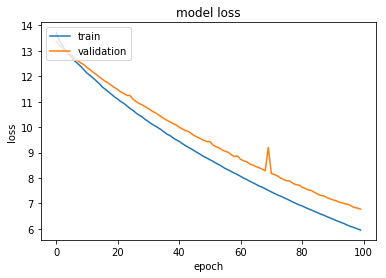

In [58]:
from keras import regularizers
import matplotlib.pyplot as plt 

#stop epochs when deltas become close together
batch_size = 256
epochs = 100
learning_rate = 5e-3
verb = 2

model = neural_network_classifier(learning_rate)
#model.fit(X_train, y_train)
history = model.fit(X_train, y_train, 
              epochs = epochs, 
              #batch_size = batch_size,          
              validation_split = 0.25,
              verbose = verb,
              shuffle = True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()




In [59]:
sum = 0.0
for val in history.history['acc']:
    sum+=val
avg = sum/epochs
print("Average Training Accuracy: ", avg)


sum = 0.0
for val in history.history['val_acc']:
    sum+=val
avg = sum/epochs
print("Average Validation Accuracy: ", avg)

print("Last Training Accuracy: ", history.history['acc'][99])
print("Last Validation Accuracy: ", history.history['val_acc'][99])


sum = 0.0
for i in range(90,100):
    sum+= history.history['val_acc'][i]
avg = sum / 10.0
print("Average of last 10 validation: ", avg)


Average Training Accuracy:  0.9543944353333472
Average Validation Accuracy:  0.7354656860290787
Last Training Accuracy:  0.9942716857610474
Last Validation Accuracy:  0.740196077262654
Average of last 10 validation:  0.7279411758862289


In [60]:
x_testNN = np.array(x_test)
predicted = model.predict_classes(x_testNN)
correct = 0
total = len(y_test)
for i in range(0, len(y_test)):
    if (y_test[i]==pred[i]):
        correct+=1
        
print(correct)
print(total)
print(correct/total)

361
464
0.7780172413793104


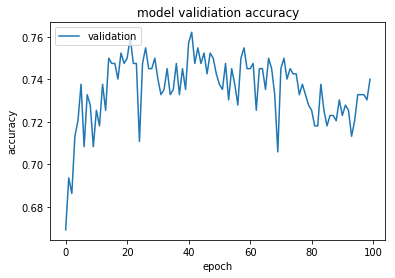

In [61]:
plt.plot(history.history['val_acc'])
#plt.plot(predicted)
plt.title('model validiation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation'], loc='upper left')
plt.show()

In [ ]:
# def mcnemar(y_true, pred_a, pred_b):
#     """McNemar's test using the chi2 distribution.
    
#     Parameters
#     ----------
#     y_true : list of actual labels
#     pred_a, pred_b : lists
#         Predictions from the two systems being evaluated.
#         Assumed to have the same length as `y_true`.
    
#     Returns
#     -------
#     float, float (the test statistic and p value)
    
#     """
#     c01 = 0
#     c10 = 0
#     for y, a, b in zip(y_true, pred_a, pred_b):
#         if (a==y) and (b!=y):
#             c01 += 1
#         elif a != y and b == y:
#             c10 += 1
#     stat = ((np.abs(c10 - c01) - 1.0)**2) / (c10 + c01)
#     df = 1
#     pval = stats.chi2.sf(stat, df)
#     return stat, pval                

In [ ]:
# results = mcnemar(y_test, pred, predicted)
# print("STAT: ", results[0])
# print("Pval: ", results[1])